In [2]:
import os 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import requests
import cv2 
from numpy.polynomial import Polynomial
from skimage.morphology import skeletonize, binary_closing, square, binary_erosion, binary_dilation, medial_axis, thin, disk, convex_hull_image, diamond, star, isotropic_closing, remove_small_objects
from skimage.filters import threshold_otsu
import json

In [3]:
sem_segm_img_path = "/Users/senneloobuyck/Documents/Thesis_project/04_matching/main_7/picked_masks/2023_RVV_1_mask_1329.jpg"
mapbox_imgs_dir_path = "/Users/senneloobuyck/Documents/Thesis_project/04_matching/main_7/mapbox_method_no_stitching/mapbox_images_for_frame_1329_RVV1"
heli_lat =  50.801275
heli_lon = 3.593557
altitude = 174.99

In [4]:
def plot_image(img):
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [5]:
def plot_patch(img, center_pixel, patch_size) : 
    # Calculate the patch boundaries
    top = center_pixel[0] - patch_size // 2
    bottom = top + patch_size
    left = center_pixel[1] - patch_size // 2
    right = left + patch_size

    # Ensure the patch boundaries stay within the image dimensions
    if top < 0:
        top = 0
    if bottom > img.shape[0]:
        bottom = img.shape[0]
    if left < 0:
        left = 0
    if right > img.shape[1]:
        right = img.shape[1]

    # Extract the patch from the image
    patch = img[top:bottom, left:right]

    # Plot the patch
    plt.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))  # Assuming the image is grayscale
    plt.axis('off')  # Hide axes
    plt.show()

In [6]:
def calculate_bearing(lat1, long1, lat2, long2) : 
    lat1 = math.radians(lat1)
    long1 = math.radians(long1)
    lat2 = math.radians(lat2)
    long2 = math.radians(long2)

    d_long = long2 - long1

    y = math.sin(d_long) * math.cos(lat2)
    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_long)

    brng = math.atan2(y, x)

    brng = math.degrees(brng)
    brng = (brng + 360) % 360
    # brng = 360 - brng # count degrees clockwise - remove to make counter-clockwise
    return brng

In [7]:
def haversine(lat1, lon1, lat2, lon2) : 
    R = 6371
    d_lat = math.radians(lat2 - lat1)
    d_lon = math.radians(lon2 - lon1)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)
    a = math.sin(d_lat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(d_lon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c * 1000
    return d

In [8]:
# calculate pitch/tilt
def calculate_pitch(heli_lat, heli_lon, intersec_lat, intersec_lon, alt) : 
    dist = haversine(heli_lat, heli_lon, intersec_lat, intersec_lon)

    # result = heli_df[(heli_df['lat'] == heli_lat) & (heli_df['lng'] == heli_lon)]
    # if not result.empty:
    #    altitude = result.iloc[0]['alt']

    print(f"Distance: {dist}")
    print(f"Altitude: {alt}")

    alpha_radian = math.atan2(alt, dist)
    alpha_degrees = alpha_radian * (180.0 / math.pi)
    pitch = 90 - alpha_degrees
    return pitch 

In [9]:
def get_mapbox_intersection_image(lat, lon, bearing, tilt) : 
    if tilt > 60 :
        tilt = 60
    zoom = 18
    width = 512
    height = 512
    access_token = "pk.eyJ1Ijoic2VubmVsb29idXljayIsImEiOiJjbG1zeDVreHowZmw5Mm1xY2lxeTFtYTB2In0.ymj-xZAfeeivbksi1PJttw" 
    styles_url = "mapbox://styles/senneloobuyck/cllcojw8d00wy01pb6rqcdmm5"

    style_code = styles_url.split('/')[-1]

    url = f"https://api.mapbox.com/styles/v1/senneloobuyck/{style_code}/static/{str(lon)},{str(lat)},{str(zoom)},{str(bearing)},{str(tilt)}/{str(width)}x{str(height)}?access_token={access_token}"

    response = requests.get(url)

    if response.status_code == 200:
        with open(f"{lat}_{lon}.jpg", "wb") as f:
            f.write(response.content)
        print(f"Image saved as {lat}_{lon}.jpg")
    else:
        print("Failed to retrieve image for intersection lat = " + str(lat) + ", lon = " + str(lon))
        print(response.text[:100])

In [10]:
def get_intersection_coordinates(lat, lon) : 
    # some lists and dataframes to store the data
    nodes = []
    intersection_nodes = []
    df_nodes = pd.DataFrame(columns=['id', 'lat', 'lon'])
    df_intersections = pd.DataFrame(columns=['lat', 'lon'])

    overpass_url = "http://overpass-api.de/api/interpreter"


    # first get the ways around the point 
    # .w is a temporary variable that stores the result of the first query
    # node(way_cnt:2-);   // select those nodes that are members of two or more of the given ways
    overpass_query = f"""[out:json];
                        way(around: 300, {lat},{lon})["highway"~"(motorway|trunk|primary|secondary|tertiary|unclassified|residential|motorway_link|trunk_link|primary_link|secondary_link|tertiary_link|living_street|service|pedestrian)"]->.w;
                        node(way_cnt.w:2-);  
                        out;"""

    response = requests.get(overpass_url, params={'data': overpass_query})

    # print(response.json()['elements'])

    for item in response.json()['elements']:
        df_intersections.loc[len(df_intersections)] = {'lat': item['lat'], 'lon': item['lon']}


    # print(df_intersections)
    return df_intersections

In [11]:
df_intersections = get_intersection_coordinates(heli_lat, heli_lon)

# read in csv file with heli coordinates
heli_path = "/Users/senneloobuyck/Documents/Thesis_project/01_inputs/csv-files/2023 Ronde van Vlaanderen 1 heli.csv"
heli_df = pd.read_csv(heli_path)
heli_df['lat'] = heli_df.apply(lambda row: float(row['lat']) * 1 if row['NS'] == 'N' else float(row['lat']) * (-1), axis=1)
heli_df['lng'] = heli_df.apply(lambda row: float(row['lng']) * 1 if row['EW'] == 'E' else float(row['lng']) * (-1), axis=1)
heli_df = heli_df[['lat', 'lng', 'alt', 'seconds_from_start']]

for index, row in df_intersections.iterrows() : 
    print(f"Intersection: {row['lat']},{row['lon']}")
    bearing = calculate_bearing(heli_lat, heli_lon, row['lat'], row['lon'])
    print(f"Bearing = {bearing}")
    pitch = calculate_pitch(heli_lat, heli_lon, row['lat'], row['lon'], alt=altitude)
    print(f"Pitch = {pitch}")
    # get_mapbox_intersection_image(row['lat'], row['lon'], bearing, pitch)

Intersection: 50.799533,3.5919185
Bearing = 210.73095314270734
Distance: 225.3439034128123
Altitude: 174.99
Pitch = 52.16900189622998
Intersection: 50.8009587,3.5921857
Bearing = 249.95070046771502
Distance: 102.58789718612624
Altitude: 174.99
Pitch = 30.380966365393583
Intersection: 50.7989069,3.5945538
Bearing = 165.10180794850226
Distance: 272.47986418065693
Altitude: 174.99
Pitch = 57.2909123720395
Intersection: 50.801701,3.5923755
Bearing = 299.7050365859298
Distance: 95.59304576981852
Altitude: 174.99
Pitch = 28.64677342692407
Intersection: 50.8007761,3.5927866
Bearing = 224.303155548858
Distance: 77.51629429836424
Altitude: 174.99
Pitch = 23.892172292468288
Intersection: 50.8008391,3.5926009
Bearing = 234.1949407109589
Distance: 82.84958521318617
Altitude: 174.99
Pitch = 25.335367242831467
Intersection: 50.803516,3.5951223
Bearing = 23.817925873020442
Distance: 272.3873044562206
Altitude: 174.99
Pitch = 57.28206071750175
Intersection: 50.8037365,3.5944906
Bearing = 13.4793239914

In [12]:
def get_skeleton(mask_bgr, contour) : 
    print("Getting the skeleton")

    mask_gray = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2GRAY)

    # draw contour in white on black background
    contour_mask_gray = np.zeros_like(mask_gray)
    cv2.drawContours(contour_mask_gray, [contour], -1, 255, -1)

    ret, contour_mask_thresh_gray = cv2.threshold(contour_mask_gray, 127, 255, cv2.THRESH_BINARY)
    contour_mask_thresh_bgr = cv2.cvtColor(contour_mask_thresh_gray, cv2.COLOR_GRAY2BGR)
    # plot_image(contour_mask_thresh_bgr)

    
    # To avoid the precision loss when converting the image to bool, 
    # you can also binarize the image using one of the available thresholding algorithms
    thresh_otsu = threshold_otsu(contour_mask_thresh_gray)
    contour_mask_thresh_gray = contour_mask_thresh_gray > thresh_otsu
    
    # skeletonize
    # skeleton_gray = (skeletonize(contour_mask_gray)).astype(np.uint8)
    skeleton_gray = skeletonize(contour_mask_thresh_gray, method='lee').astype(np.uint8)

    # np.set_printoptions(threshold=np.inf)
    # print("Skeleton image values:")
    # print(skeleton_gray)


    # plt.figure(figsize=(20,10))
    # plt.imshow(skeleton_gray, cmap='gray', interpolation='nearest')
    # plt.show()

    skeleton_bgr = cv2.cvtColor(skeleton_gray, cv2.COLOR_GRAY2BGR)

    return skeleton_bgr
            

In [13]:
def is_valid_intersection(neighbourhood_patch) : 
    # A list of valid intersections             
    # These are in the format (clockwise order)
    # 2 3 4
    # 1 C 5
    # 8 7 6 
    validIntersection = [[0,1,0,1,0,0,1,0],[0,0,1,0,1,0,0,1],[1,0,0,1,0,1,0,0],
                         [0,1,0,0,1,0,1,0],[0,0,1,0,0,1,0,1],[1,0,0,1,0,0,1,0],
                         [0,1,0,0,1,0,0,1],[1,0,1,0,0,1,0,0],[0,1,0,0,0,1,0,1],
                         [0,1,0,1,0,0,0,1],[0,1,0,1,0,1,0,0],[0,0,0,1,0,1,0,1],
                         [1,0,1,0,0,0,1,0],[1,0,1,0,1,0,0,0],[0,0,1,0,1,0,1,0],
                         [1,0,0,0,1,0,1,0],[1,0,0,1,1,1,0,0],[0,0,1,0,0,1,1,1],
                         [1,1,0,0,1,0,0,1],[0,1,1,1,0,0,1,0],[1,0,1,1,0,0,1,0],
                         [1,0,1,0,0,1,1,0],[1,0,1,1,0,1,1,0],[0,1,1,0,1,0,1,1],
                         [1,1,0,1,1,0,1,0],[1,1,0,0,1,0,1,0],[0,1,1,0,1,0,1,0],
                         [0,0,1,0,1,0,1,1],[1,0,0,1,1,0,1,0],[1,0,1,0,1,1,0,1],
                         [1,0,1,0,1,1,0,0],[1,0,1,0,1,0,0,1],[0,1,0,0,1,0,1,1],
                         [0,1,1,0,1,0,0,1],[1,1,0,1,0,0,1,0],[0,1,0,1,1,0,1,0],
                         [0,0,1,0,1,1,0,1],[1,0,1,0,0,1,0,1],[1,0,0,1,0,1,1,0],
                         [1,0,1,1,0,1,0,0]]
    
    if neighbourhood_patch in validIntersection : 
        return True
    else : 
        return False

In [14]:
def get_skeleton_intersection(skeleton):
    """ Given a skeletonised image, it will give the coordinates of the intersections of the skeleton"""
    print("Getting intersections in skeleton (more than 2 neighbours)")
    skeleton_gray = cv2.cvtColor(skeleton, cv2.COLOR_BGR2GRAY)
    image = skeleton_gray.copy()
    image = image/255
    intersections = []
    for y in range(1,len(image)-1):
        for x in range(1,len(image[y])-1):
            # if we have a white pixel
            if image[y][x] == 1:
                neighbourhood_patch = [image[y][x-1], image[y-1][x-1], image[y-1][x], image[y-1][x+1], image[y][x+1], image[y+1][x+1], image[y+1][x], image[y+1][x-1]]
                if is_valid_intersection(neighbourhood_patch):
                    intersections.append((y,x))
    # Filter intersections to make sure we don't count them twice or ones that are very close together
    # for point1 in intersections:
    #     for point2 in intersections:
    #         if (((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) < 10**2) and (point1 != point2):
    #             intersections.remove(point2)
    # Remove duplicates
    return intersections


In [15]:
def get_neighbour_pixels(skel_contour_bgr, intersec) : 
    
    # print(f"Getting neighbour pixels for pixel {intersec}")
    
    skel_contour_bgr_copy = skel_contour_bgr.copy()
    
    # converting to grayscale gives false values
    # skel_contour_gray = cv2.cvtColor(skel_contour_bgr, cv2.COLOR_BGR2GRAY)

    # plot_patch(skel_contour_bgr_copy, intersec, 7)


    # Calculate neighbour pixels that define the roads that intersect (in patch values)
    road_neighbour_pixels = []
    for x in range(-1,2):
        for y in range(-1,2):
            pixel_color = skel_contour_bgr[intersec[0] + y, intersec[1] + x]
            # print(f"Pixel color = {pixel_color}")
            if np.all(pixel_color == np.array([255, 255, 255])) and (x != 0 or y != 0):
                road_neighbour_pixels.append((intersec[0]+y, intersec[1]+x))
                skel_contour_bgr_copy[intersec[0]+y, intersec[1]+x] = (0,0,255)
                # print(f"Neighbour pixel for pixel {intersec} within image: {intersec[0]+y}, {intersec[1]+x}")

    # plot_patch(skel_contour_bgr_copy, intersec, 7)

    return road_neighbour_pixels

In [16]:
def get_descriptors(skeleton_bgr, intersections, visualize=False) : 
    skeleton_gray = cv2.cvtColor(skeleton_bgr, cv2.COLOR_BGR2GRAY)

    dict_angles = {}
    dict_other_intersecs = {}
    descriptors = []

    skeleton_gray = cv2.cvtColor(skeleton_bgr, cv2.COLOR_BGR2GRAY)
    image = skeleton_gray.copy()
    image = image/255

    for intersection_pixel in intersections :
        dict_angles[intersection_pixel] = []
        dict_other_intersecs[intersection_pixel] = []
        # print(f"Getting neighbour pixels for intersection pixel {intersection_pixel}")
        neighbour_road_pixels = get_neighbour_pixels(skeleton_bgr, intersection_pixel)
        # print(f"Neighbour pixels: {neighbour_road_pixels}")

        for neighbour_pixel in neighbour_road_pixels :
            processed_pixels = [intersection_pixel] + neighbour_road_pixels
            road_pixels = []
            end_for_intersec_neighbour_pixel = False
            reference_pixel = neighbour_pixel
            count = 0
            count_treshold = 12
            skip_count_threshold = 2
            
            while count < count_treshold :
                # print(f"Getting new neighbour pixels for reference pixel {reference_pixel}")
                new_neighbour_pixels = get_neighbour_pixels(skeleton_bgr, reference_pixel)
                # print(f"New neighbour pixels: {new_neighbour_pixels}")


                new_neighbours_not_processed = [pixel for pixel in new_neighbour_pixels if pixel not in processed_pixels]
                if len(new_neighbours_not_processed) > 0 :
                    new_neighbour_pixel = new_neighbours_not_processed[0]
                    y, x = new_neighbour_pixel
                    new_neighbour_patch = [image[y][x-1], image[y-1][x-1], image[y-1][x], image[y-1][x+1], image[y][x+1], image[y+1][x+1], image[y+1][x], image[y+1][x-1]]
                    if is_valid_intersection(new_neighbour_patch) : 
                        # print(f"New neighbour pixel: {new_neighbour_pixel} is a valid intersection, end for this intersection pixel")
                        dict_other_intersecs[intersection_pixel].append(new_neighbour_pixel)
                        end_for_intersec_neighbour_pixel = True
                        break
                    else : 
                        processed_pixels.append(new_neighbour_pixel)
                        reference_pixel = new_neighbour_pixel

                    if count >= skip_count_threshold : 
                        if count == skip_count_threshold :
                            # print("Skip count threshold reached")
                            first_road_pixel = new_neighbour_pixel
                        if count == skip_count_threshold + 1 : 
                            second_road_pixel = new_neighbour_pixel
                        road_pixels.append(new_neighbour_pixel)
                else : 
                    # print("No new neighbour pixels found, end for this intersection pixel")
                    end_for_intersec_neighbour_pixel = True
                    break
                
                if end_for_intersec_neighbour_pixel is False :
                    count += 1
                else : 
                    break
            
            if count == count_treshold :
                # print("Count threshold reached")

                skeleton_bgr_copy = skeleton_bgr.copy()

                skeleton_bgr_copy[first_road_pixel[0], first_road_pixel[1]] = [0,0,255]
                skeleton_bgr_copy[second_road_pixel[0], second_road_pixel[1]] = [0,255,0]
                # all the other road pixels in blue 
                for pixel in road_pixels :
                    if pixel != first_road_pixel and pixel != second_road_pixel :
                        skeleton_bgr_copy[pixel[0], pixel[1]] = [255,0,0]

                
                plot_patch(skeleton_bgr_copy, first_road_pixel, 23)


                # print(f"Shape of skeleton_gray: {skeleton_gray.shape}")


                # Now use the first road pixel as origin and compute the angle of the road segment
                # First reverse the y coordinates to make sure the origin is in the bottom left corner
                road_pixels = [((skeleton_gray.shape[0]-1)-pixel[0], pixel[1]) for pixel in road_pixels]
                # print(f"Road pixels: {road_pixels}")

                first_road_pixel = ((skeleton_gray.shape[0]-1)-first_road_pixel[0], first_road_pixel[1])
                second_road_pixel = ((skeleton_gray.shape[0]-1)-second_road_pixel[0], second_road_pixel[1])

                # Adjust the coordinates of road pixels and intersection to be relative to the center
                adjusted_road_pixels = [(pixel[0] - first_road_pixel[0], pixel[1] - first_road_pixel[1]) for pixel in road_pixels]
                # print(f"Adjusted road pixels: {adjusted_road_pixels}")

                second_road_pixel = (second_road_pixel[0] - first_road_pixel[0], second_road_pixel[1] - first_road_pixel[1])
                first_road_pixel = (0,0)
                # print(f"First road pixel: {first_road_pixel}")
                # print(f"Second road pixel: {second_road_pixel}")

                # For each set of coordinates, compute the best-fit line
                x_values = np.array([coord[1] for coord in adjusted_road_pixels])
                y_values = np.array([coord[0] for coord in adjusted_road_pixels])

                positive_x_directions = 0
                negative_x_directions = 0
                positive_y_directions = 0
                negative_y_directions = 0
                for x in x_values:
                    if x > 0:
                        positive_x_directions += 1
                    elif x < 0:
                        negative_x_directions += 1
                
                for y in y_values:
                    if y > 0:
                        positive_y_directions += 1
                    elif y < 0:
                        negative_y_directions += 1

                # Check if all x-values are the same
                all_x_values_same = all(x == x_values[0] for x in x_values)
                if all_x_values_same :
                    print("All x-values are the same")
                    if second_road_pixel[0] > first_road_pixel[0] :
                        # index 0 because y coordinate needed (index 1 is x coordinate)
                        angle = 90
                    else :
                        angle = 270
                    print(f"Angle is: {angle}")
                    dict_angles[intersection_pixel].append(angle)
                    continue

                line = np.polyfit(x_values, y_values, deg=1)
                
                # print(f"Line: {line}")

                # Now show the line on the patch
                a = line[0]
                b = line[1]
                y = a * x_values + b
                if visualize : 
                    plt.plot(x_values, y)
                    plt.show()

                # The slope of each line gives the direction of the road segment it fits
                angle = np.degrees(np.arctan(a))
                # print(f"Angle: {angle}")

                if angle == 0 and negative_x_directions > positive_x_directions :
                    angle = 180

                if angle > 0 and negative_y_directions > positive_y_directions :
                    angle = angle + 180
                
                if angle < 0 :
                    if negative_y_directions < positive_y_directions :
                        angle = angle + 180
                    else : 
                        angle = angle + 360

                print(f"Angle is: {angle}")
                dict_angles[intersection_pixel].append(angle)
            else : 
                print("Count threshold not reached")
    

    processed_intersections = []
    for intersection in dict_other_intersecs.keys() : 
        if intersection in processed_intersections :
            continue
        # print(f"dict_other_intersecs[intersection]: ")
        # print(dict_other_intersecs[intersection])
        if len(dict_other_intersecs[intersection]) == 0 :
            descriptor = dict_angles[intersection]
            sorted_descriptor = sorted(descriptor)
            descriptors.append(sorted_descriptor)
            processed_intersections.append(intersection)
        else :
            for other_intersection in dict_other_intersecs[intersection] : 
                if other_intersection not in processed_intersections : 
                    descriptor = dict_angles[intersection] + dict_angles[other_intersection]
                    sorted_descriptor = sorted(descriptor)
                    descriptors.append(sorted_descriptor)
                    processed_intersections.append(intersection)
                    processed_intersections.append(other_intersection)
                else: 
                    continue
    
    return descriptors


In [17]:
def find_descriptors_in_segmentation_image(img_path) : 
    print("Finding descriptors in segmentation image")
    
    img_bgr = cv2.imread(img_path)
    print("Segmentation image")
    plot_image(img_bgr)

    closing_bgr = isotropic_closing(img_bgr, radius=20)
    closing_bgr = closing_bgr.astype(np.uint8) * 255
    print("Isotropic closing of segmentation image")
    plot_image(closing_bgr)

    closing_bgr_copy = closing_bgr.copy()
    mask_bgr_copy = closing_bgr.copy()
    closing_gray = cv2.cvtColor(closing_bgr, cv2.COLOR_BGR2GRAY)

    contours, hierarchy = cv2.findContours(closing_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Number of contours: {len(contours)}")
    cv2.drawContours(closing_bgr_copy, contours, contourIdx=-1, color=(255, 0, 0), thickness=2)

    descriptors = []

    for contour in contours :
        contour_length = cv2.arcLength(contour, closed=True)
        print(f"Contour length: {contour_length}")
        contour_area = cv2.contourArea(contour)
        print(f"Contour area: {contour_area}")

        # measure the irregularity of the polygon
        if contour_length != 0 :
            convex_hull = cv2.convexHull(contour)
            convex_hull_area = cv2.contourArea(convex_hull)
            print(f"Convex hull area: {convex_hull_area}")
            # cv2.polylines(mask_bgr_copy, [convex_hull], isClosed=True, color=(0, 255, 0), thickness=3)
            solidity = contour_area / convex_hull_area

            # get skeleton of the contour
            skeleton_contour_bgr = get_skeleton(mask_bgr_copy, contour)
            
            # find the intersections in the skeleton
            skel_intersections = get_skeleton_intersection(skeleton_contour_bgr)
            
            #  make a decision based on the solidity
            if solidity < 0.60 and skel_intersections != [] :
                print(f"Solidity = {solidity} -> this contour can be related to an intersection in the road")

                # further processing
                if skel_intersections == [] : 
                    print("No intersection is found in a possible intersection contour")
                else : 
                    print(f"Intersections = {skel_intersections}")
                    
                    # visualization
                    skeleton_contour_bgr_copy = skeleton_contour_bgr.copy()
                    for intersection in skel_intersections :
                        skeleton_contour_bgr_copy[intersection[0], intersection[1]] = [0, 0, 255]
                    plot_image(skeleton_contour_bgr_copy)

                    # now try and match intersection with the openstreetmap images
                    descriptors = get_descriptors(skeleton_contour_bgr, skel_intersections)
                    
            else :
                print(f"Solidity = {solidity} -> no intersection in this contour")
        
    if descriptors == [] :
        return None
    else :
        return descriptors
    

Finding descriptors in segmentation image
Segmentation image


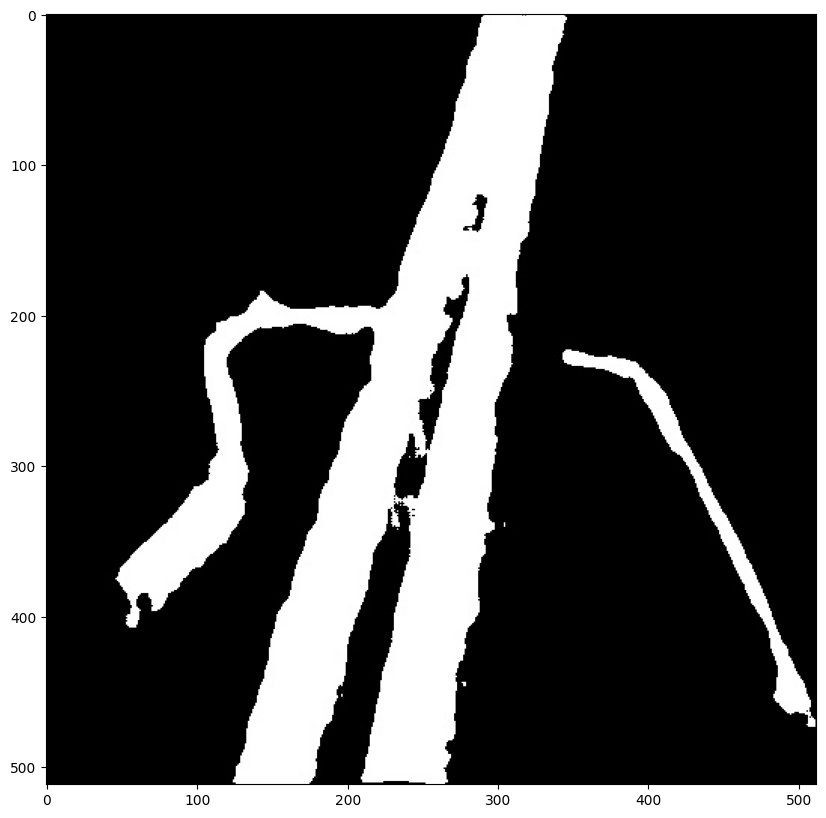

Isotropic closing of segmentation image


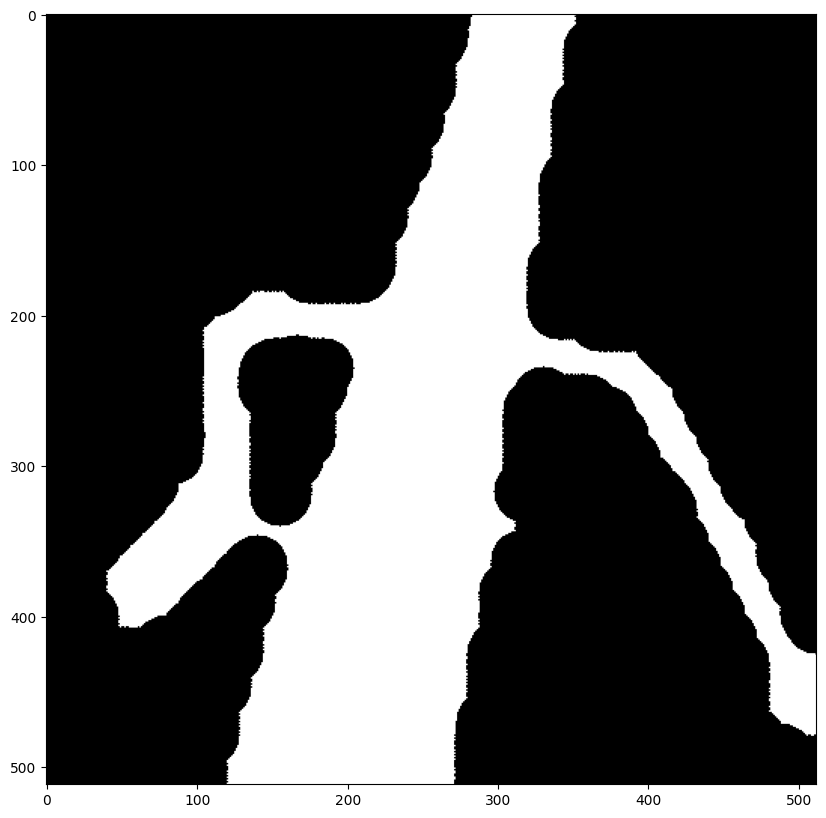

Number of contours: 1
Contour length: 2571.1252311468124
Contour area: 80621.0
Convex hull area: 160719.0
Getting the skeleton
Getting intersections in skeleton (more than 2 neighbours)
Solidity = 0.5016270633839185 -> this contour can be related to an intersection in the road
Intersections = [(194, 276), (270, 220)]


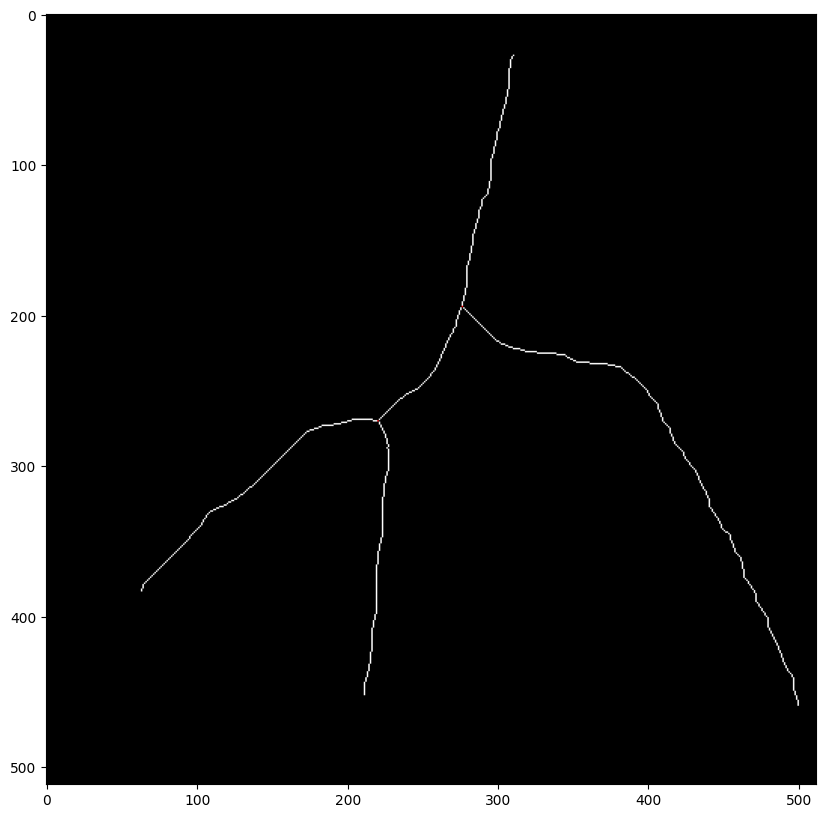

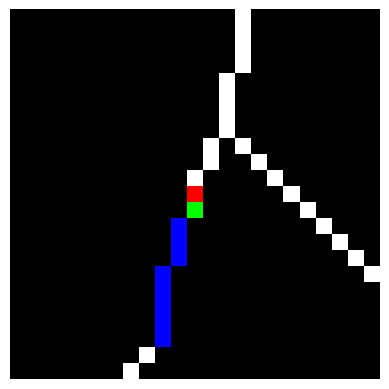

Angle is: 253.42904883308614


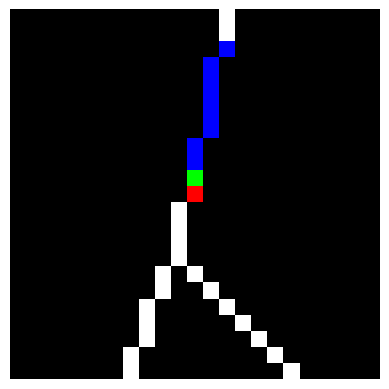

Angle is: 76.04549082686316


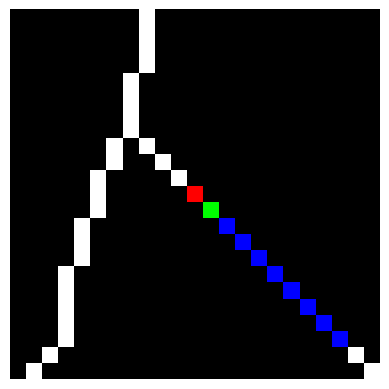

Angle is: 315.0


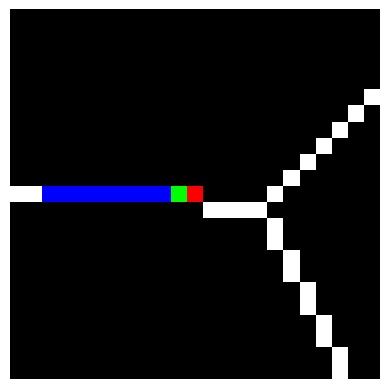

Angle is: 180


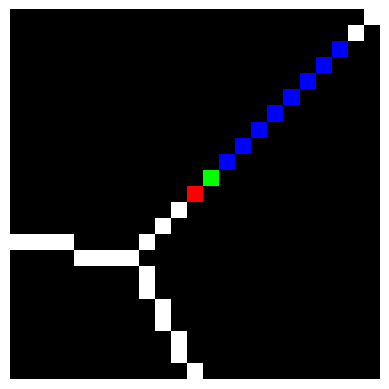

Angle is: 45.0


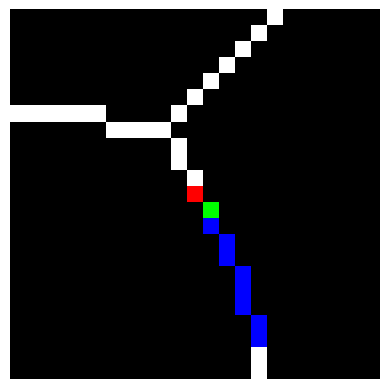

Angle is: 294.39529595601016
Array of descriptors: [[76.04549082686316, 253.42904883308614, 315.0], [45.0, 180, 294.39529595601016]]


In [18]:
# segm_img_des = find_descriptors_in_segmentation_image(sem_segm_img_path)
segm_img_des = find_descriptors_in_segmentation_image(sem_segm_img_path) # without pruning
print(f"Array of descriptors: {segm_img_des}")

In [19]:
def find_descriptors_in_mapbox_image(img_path, image_name, vis=False) : 
    img_bgr = cv2.imread(img_path)
    # print("Mapbox image")
    # plot_image(img_bgr)

    new_width, new_height = img_bgr.shape[1], img_bgr.shape[0] - 100 
    cropped_img_bgr = img_bgr[0:new_height, 0:new_width]
    print("Cropped mapbox image")
    if vis : 
        plot_image(cropped_img_bgr)

    print("Binary thresholding")
    img_gray = cv2.cvtColor(cropped_img_bgr, cv2.COLOR_BGR2GRAY)
    ret, thresh_gray = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
    thresh_bgr = cv2.cvtColor(thresh_gray, cv2.COLOR_GRAY2BGR)
    if vis :
        plot_image(thresh_bgr)

    closing_bgr = isotropic_closing(thresh_bgr, radius=3)
    closing_bgr = closing_bgr.astype(np.uint8) * 255
    closing_gray = cv2.cvtColor(closing_bgr, cv2.COLOR_BGR2GRAY)
    print("Isotropic closing of segmentation image")
    if vis : 
        plot_image(closing_bgr)

    # To avoid the precision loss when converting the image to bool, 
    # you can also binarize the image using one of the available thresholding algorithms
    thresh_otsu = threshold_otsu(closing_gray)
    mask_gray = closing_gray > thresh_otsu
    
    # Skeletonize
    # skeleton_gray = (skeletonize(contour_mask_gray)).astype(np.uint8)
    skeleton_gray = skeletonize(mask_gray, method='lee').astype(np.uint8)

    skeleton_bgr = cv2.cvtColor(skeleton_gray, cv2.COLOR_GRAY2BGR)
    
    # find the intersections in the skeleton
    skel_intersections = get_skeleton_intersection(skeleton_bgr)

    print(f"{len(skel_intersections)} intersections found in the skeleton:")
    print(skel_intersections)

    descriptors = []
            
    #  if there are intersections
    if skel_intersections != [] :
        # visualization
        skeleton_bgr_copy = skeleton_bgr.copy()
        for intersection in skel_intersections :
            skeleton_bgr_copy[intersection[0], intersection[1]] = [0, 0, 255]

        if vis : 
            plot_image(skeleton_bgr_copy)


        print(f"There are intersections in mapbox image {image_name}")
        descriptors = get_descriptors(skeleton_bgr, skel_intersections, visualize = vis)   
    else :
        print("No intersections found in the skeleton")
        
    if descriptors == [] :
        return None
    else :
        return descriptors

**************************************************
Mapbox image: 50.799644_3.5930147.jpg
**************************************************
Cropped mapbox image
Binary thresholding
Isotropic closing of segmentation image
Getting intersections in skeleton (more than 2 neighbours)
1 intersections found in the skeleton:
[(254, 258)]
There are intersections in mapbox image 50.799644_3.5930147.jpg


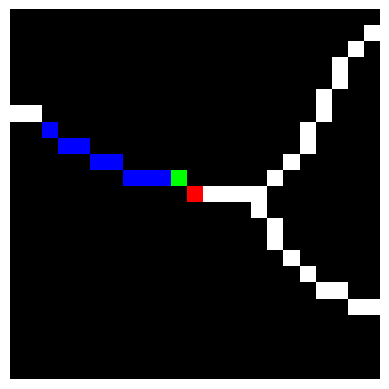

Angle is: 158.79978334435896


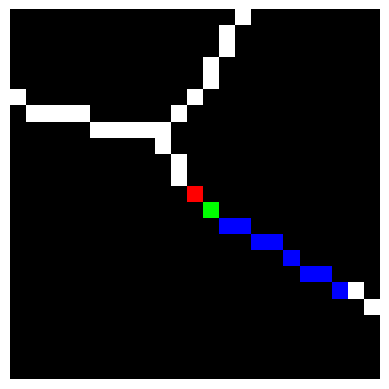

Angle is: 328.02584064687085


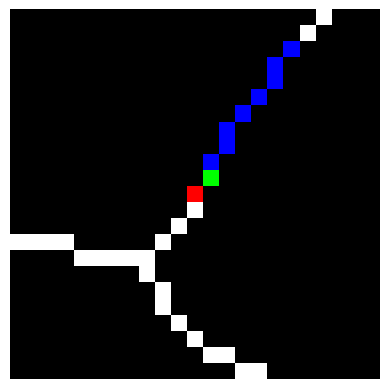

Angle is: 55.89947668419478
Descriptors for mapbox image 50.799644_3.5930147.jpg:
[[55.89947668419478, 158.79978334435896, 328.02584064687085]]
Number of descriptors: 1
Descriptor of segmentation image:
[76.04549082686316, 253.42904883308614, 315.0]
Descriptor of mapbox image:
[55.89947668419478, 158.79978334435896, 328.02584064687085]
Angle of segmentation image: 76.04549082686316
Angle of mapbox image: 55.89947668419478
Angle of mapbox image: 158.79978334435896
Angle of mapbox image: 328.02584064687085
Best diff = 20.146014142668378 with angle 55.89947668419478
Angle of segmentation image: 253.42904883308614
Angle of mapbox image: 55.89947668419478
Angle of mapbox image: 158.79978334435896
Angle of mapbox image: 328.02584064687085
Best diff = 74.5967918137847 with angle 328.02584064687085
Angle of segmentation image: 315.0
Angle of mapbox image: 55.89947668419478
Angle of mapbox image: 158.79978334435896
Angle of mapbox image: 328.02584064687085
Best diff = 156.20021665564104 with an

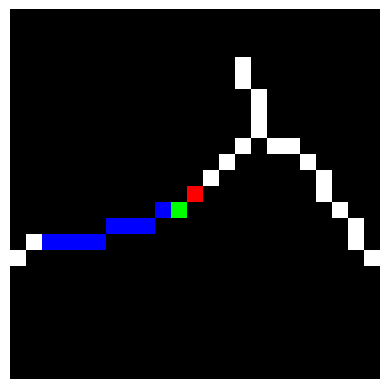

Angle is: 198.12186024790137
Count threshold not reached


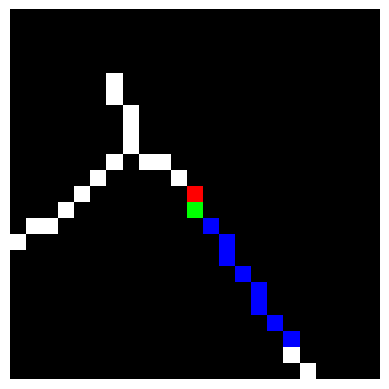

Angle is: 304.46907214732516


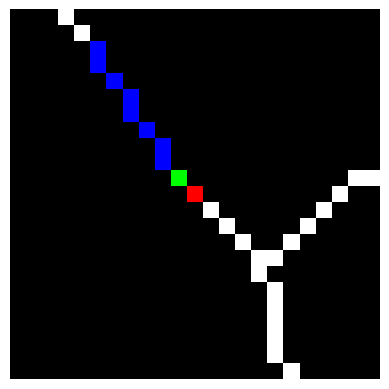

Angle is: 124.46907214732516


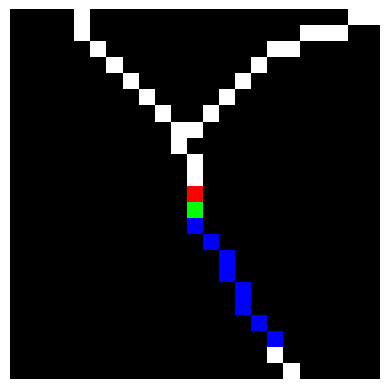

Angle is: 300.7841465263264


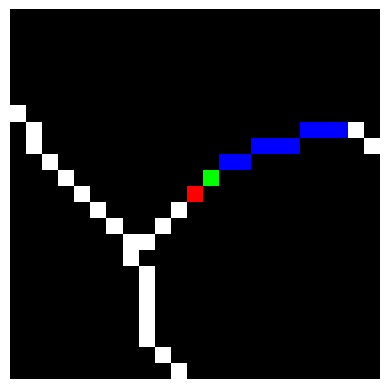

Angle is: 22.98871680208065
Descriptors for mapbox image 50.799533_3.5919185.jpg:
[[198.12186024790137, 304.46907214732516], [22.98871680208065, 124.46907214732516, 300.7841465263264]]
Number of descriptors: 2
Descriptor of segmentation image:
[76.04549082686316, 253.42904883308614, 315.0]
Descriptor of mapbox image:
[198.12186024790137, 304.46907214732516]
Descriptor of mapbox image:
[22.98871680208065, 124.46907214732516, 300.7841465263264]
Angle of segmentation image: 76.04549082686316
Angle of mapbox image: 22.98871680208065
Angle of mapbox image: 124.46907214732516
Angle of mapbox image: 300.7841465263264
Best diff = 48.423581320462006 with angle 124.46907214732516
Angle of segmentation image: 253.42904883308614
Angle of mapbox image: 22.98871680208065
Angle of mapbox image: 124.46907214732516
Angle of mapbox image: 300.7841465263264
Best diff = 47.35509769324028 with angle 300.7841465263264
Angle of segmentation image: 315.0
Angle of mapbox image: 22.98871680208065
Angle of mapbo

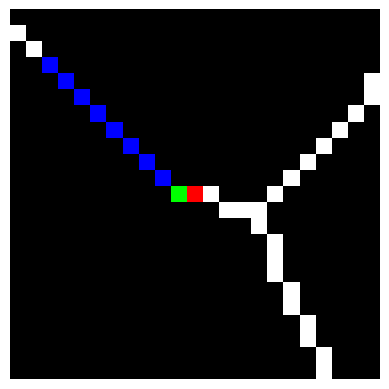

Angle is: 136.60600298928225


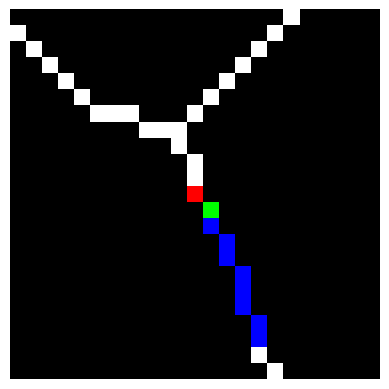

Angle is: 294.39529595601016


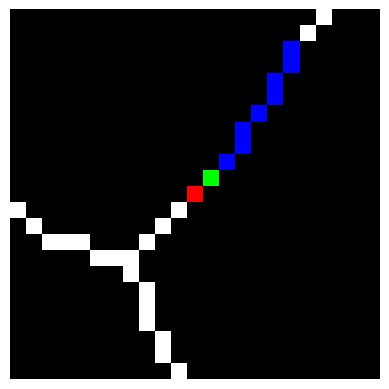

Angle is: 55.25119875081743


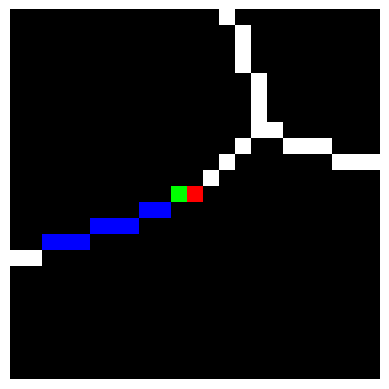

Angle is: 200.2892005377698


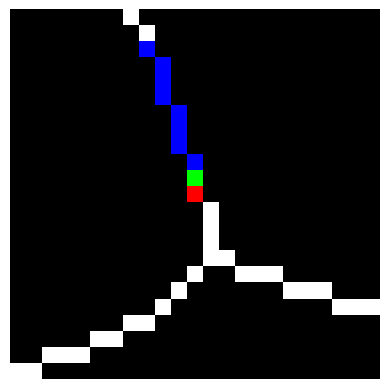

Angle is: 109.57312583041019


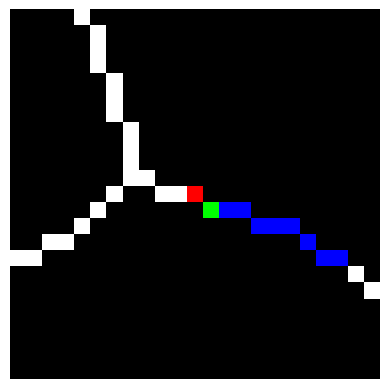

Angle is: 337.01128319791934


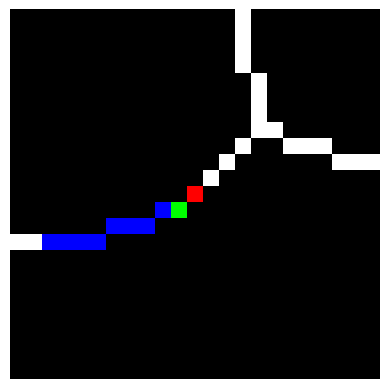

Angle is: 198.12186024790137


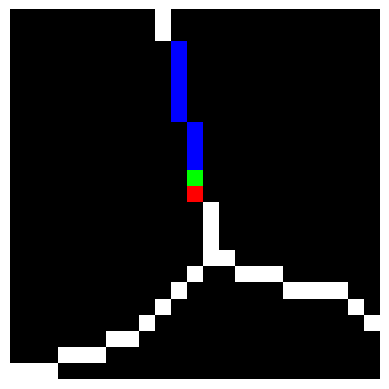

Angle is: 101.30993247402021
Count threshold not reached


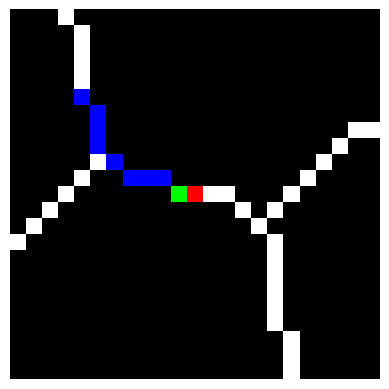

Angle is: 141.74557964748286


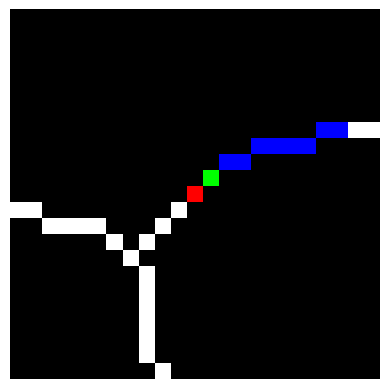

Angle is: 21.501434324047914


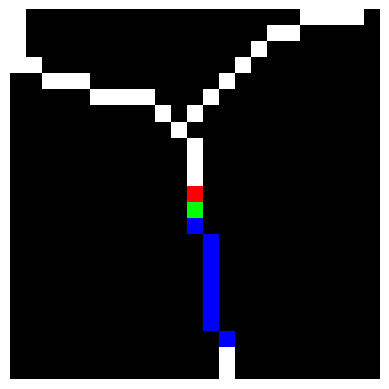

Angle is: 283.4957332807958


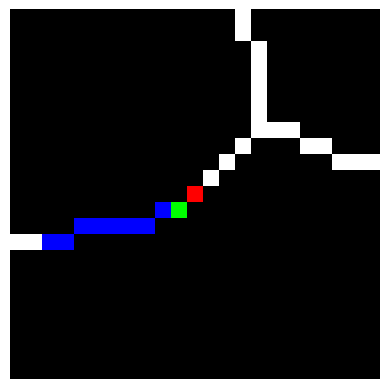

Angle is: 195.57782577431104


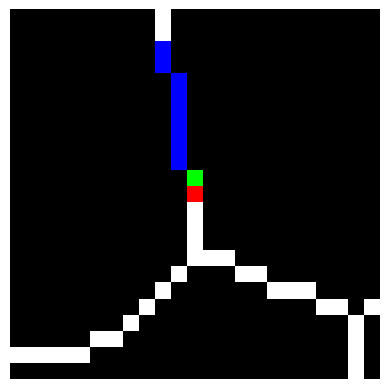

Angle is: 104.03624346792647
Count threshold not reached


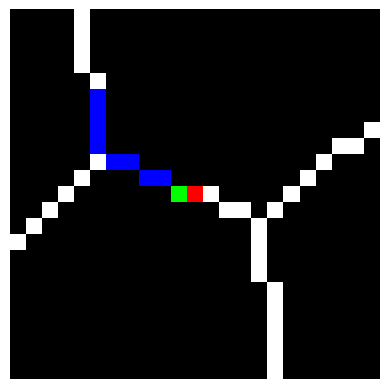

Angle is: 141.42969302095804


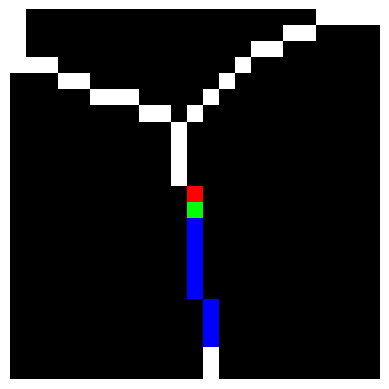

Angle is: 281.30993247402023


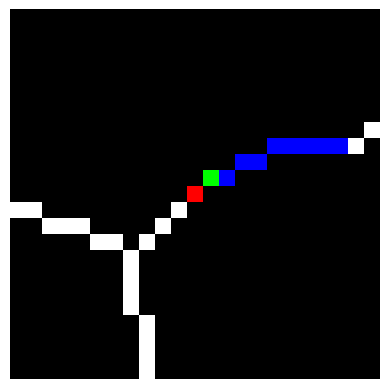

Angle is: 18.434948822922017
Descriptors for mapbox image 50.8007761_3.5927866.jpg:
[[55.25119875081743, 136.60600298928225, 294.39529595601016], [109.57312583041019, 200.2892005377698, 337.01128319791934], [21.501434324047914, 101.30993247402021, 141.74557964748286, 198.12186024790137, 283.4957332807958], [18.434948822922017, 104.03624346792647, 141.42969302095804, 195.57782577431104, 281.30993247402023]]
Number of descriptors: 4
Descriptor of segmentation image:
[76.04549082686316, 253.42904883308614, 315.0]
Descriptor of mapbox image:
[55.25119875081743, 136.60600298928225, 294.39529595601016]
Angle of segmentation image: 76.04549082686316
Angle of mapbox image: 55.25119875081743
Angle of mapbox image: 136.60600298928225
Angle of mapbox image: 294.39529595601016
Best diff = 20.79429207604573 with angle 55.25119875081743
Angle of segmentation image: 253.42904883308614
Angle of mapbox image: 55.25119875081743
Angle of mapbox image: 136.60600298928225
Angle of mapbox image: 294.3952959

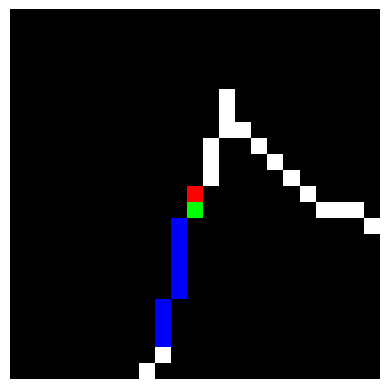

Angle is: 255.16500780574125
Count threshold not reached


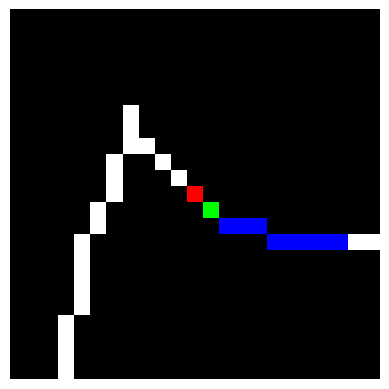

Angle is: 343.14160123226173


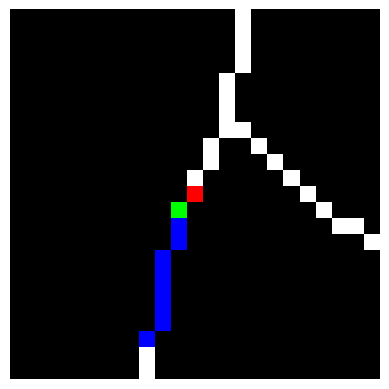

Angle is: 253.05077576617856


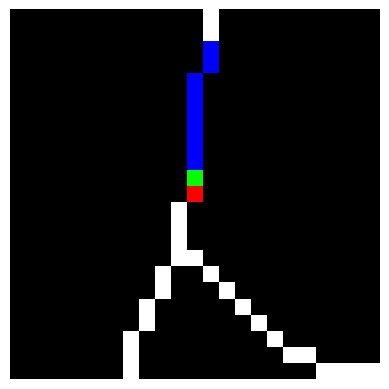

Angle is: 78.69006752597979


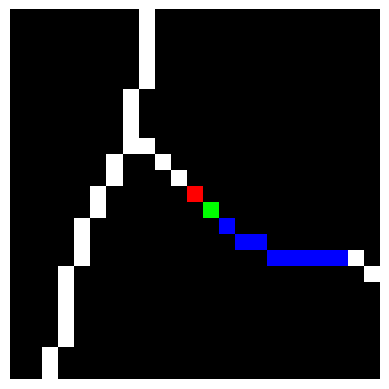

Angle is: 336.7176437865103


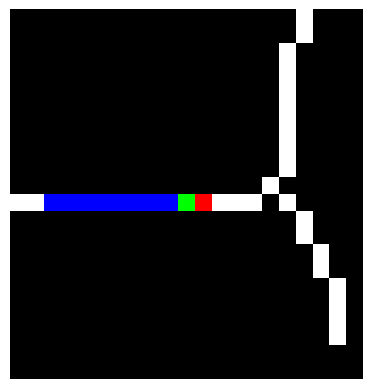

Angle is: 180


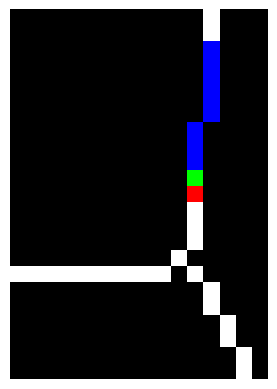

Angle is: 78.69006752597979
Count threshold not reached
Descriptors for mapbox image 50.7998387_3.5910411.jpg:
[[255.16500780574125, 343.14160123226173], [78.69006752597979, 253.05077576617856, 336.7176437865103], [78.69006752597979, 180]]
Number of descriptors: 3
Descriptor of segmentation image:
[76.04549082686316, 253.42904883308614, 315.0]
Descriptor of mapbox image:
[255.16500780574125, 343.14160123226173]
Descriptor of mapbox image:
[78.69006752597979, 253.05077576617856, 336.7176437865103]
Angle of segmentation image: 76.04549082686316
Angle of mapbox image: 78.69006752597979
Angle of mapbox image: 253.05077576617856
Angle of mapbox image: 336.7176437865103
Best diff = 2.6445766991166266 with angle 78.69006752597979
Angle of segmentation image: 253.42904883308614
Angle of mapbox image: 78.69006752597979
Angle of mapbox image: 253.05077576617856
Angle of mapbox image: 336.7176437865103
Best diff = 0.3782730669075818 with angle 253.05077576617856
Angle of segmentation image: 315.0

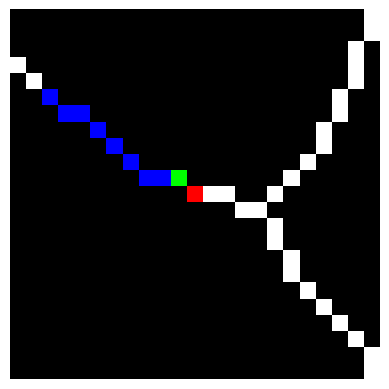

Angle is: 145.83181467497465


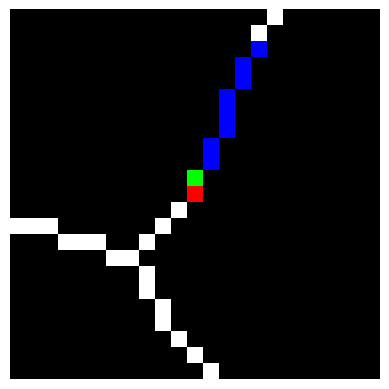

Angle is: 65.97678420183026


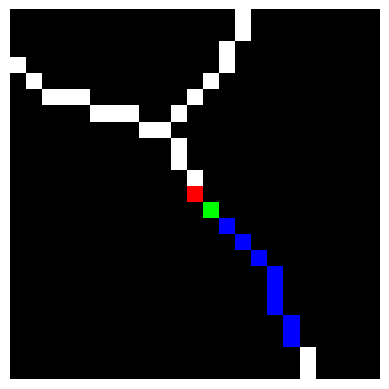

Angle is: 305.8489591001908


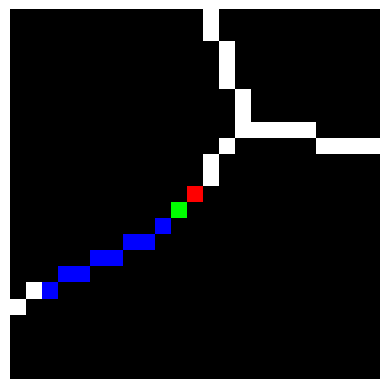

Angle is: 211.47168453362733


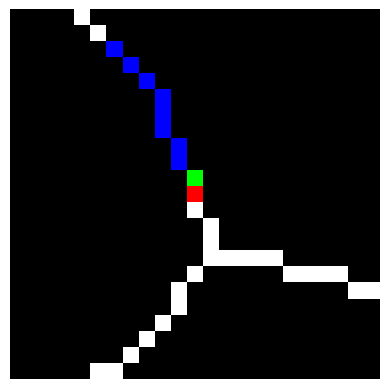

Angle is: 119.1676133795778


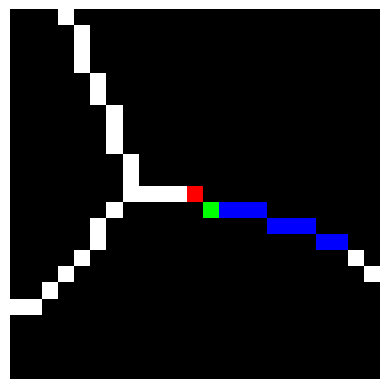

Angle is: 343.14160123226173


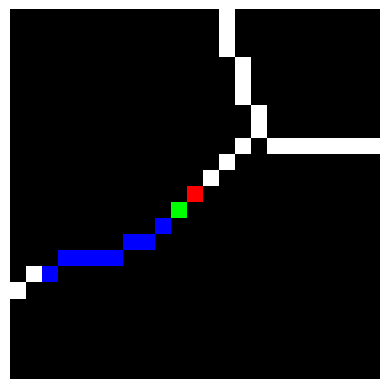

Angle is: 205.86635679409454


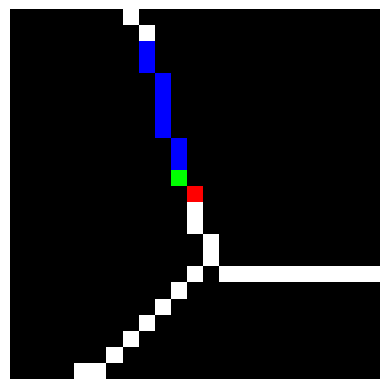

Angle is: 108.29451827198469
Count threshold not reached
Count threshold not reached


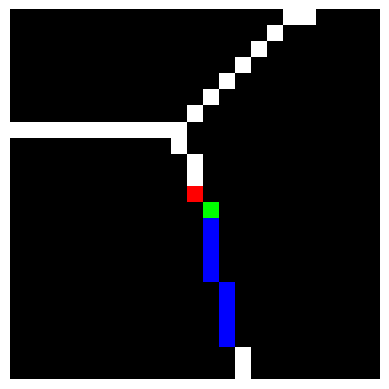

Angle is: 283.95450917313684


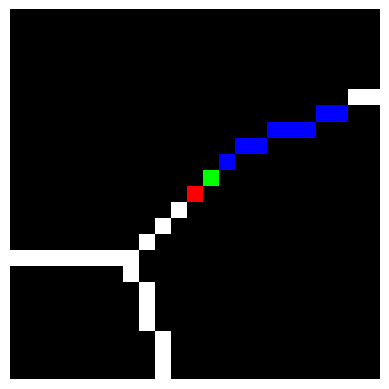

Angle is: 27.801458779934144


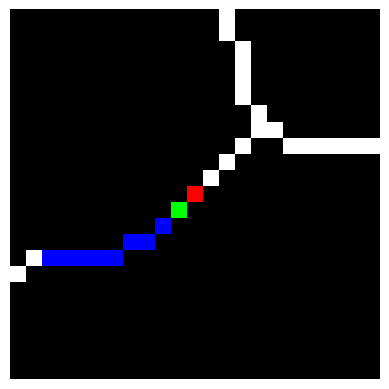

Angle is: 203.28235621348972


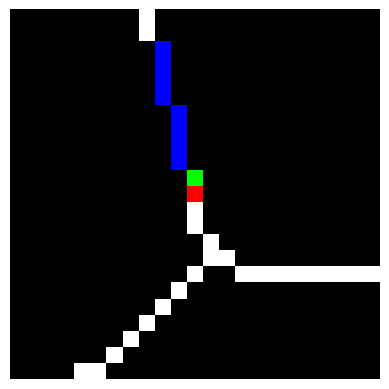

Angle is: 105.64224645720873
Count threshold not reached


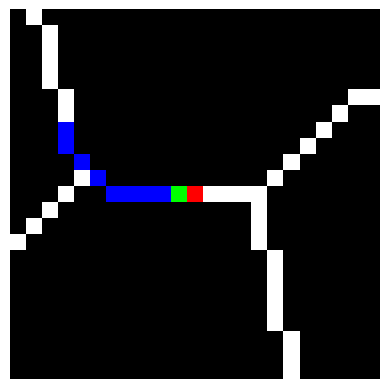

Angle is: 156.72709593591802


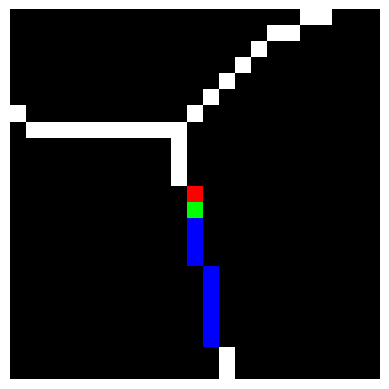

Angle is: 281.30993247402023


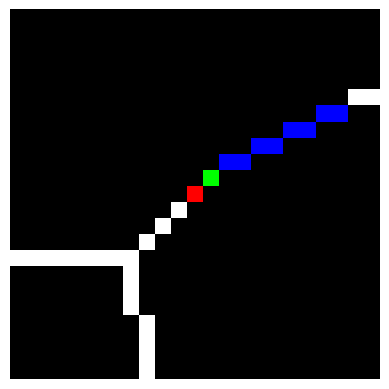

Angle is: 28.342154443421347
Descriptors for mapbox image 50.8008391_3.5926009.jpg:
[[65.97678420183026, 145.83181467497465, 305.8489591001908], [119.1676133795778, 211.47168453362733, 343.14160123226173], [27.801458779934144, 108.29451827198469, 205.86635679409454, 283.95450917313684], [28.342154443421347, 105.64224645720873, 156.72709593591802, 203.28235621348972, 281.30993247402023]]
Number of descriptors: 4
Descriptor of segmentation image:
[76.04549082686316, 253.42904883308614, 315.0]
Descriptor of mapbox image:
[65.97678420183026, 145.83181467497465, 305.8489591001908]
Angle of segmentation image: 76.04549082686316
Angle of mapbox image: 65.97678420183026
Angle of mapbox image: 145.83181467497465
Angle of mapbox image: 305.8489591001908
Best diff = 10.068706625032902 with angle 65.97678420183026
Angle of segmentation image: 253.42904883308614
Angle of mapbox image: 65.97678420183026
Angle of mapbox image: 145.83181467497465
Angle of mapbox image: 305.8489591001908
Best diff = 52

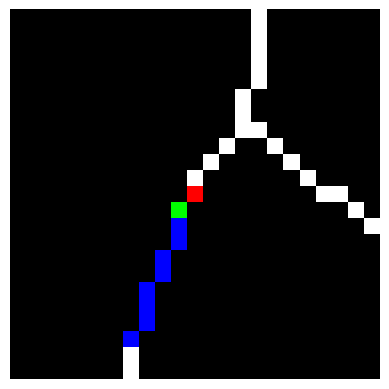

Angle is: 247.01128319791937


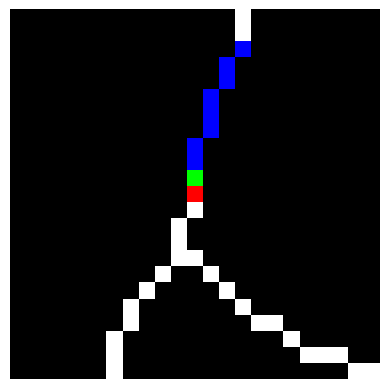

Angle is: 69.67686317033706


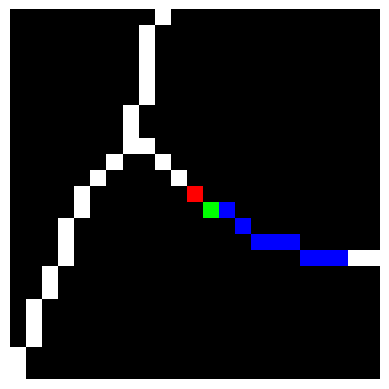

Angle is: 335.55604521958344


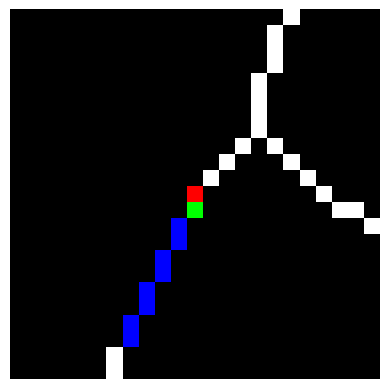

Angle is: 243.43494882292202


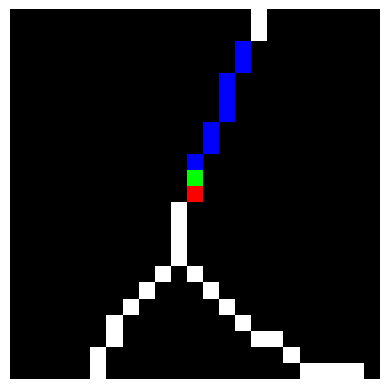

Angle is: 68.1985905136482


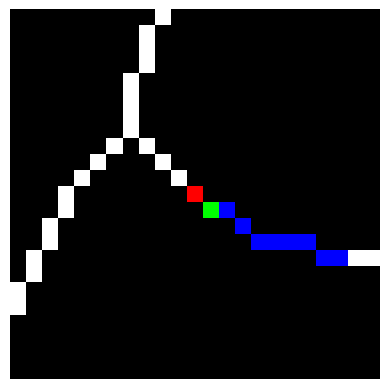

Angle is: 337.01128319791934


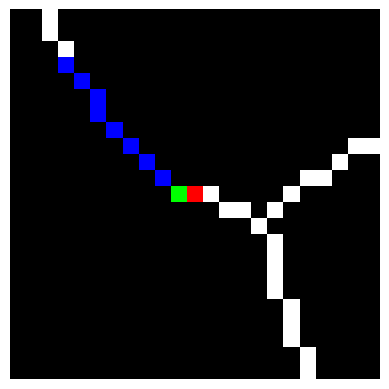

Angle is: 133.16925135197448


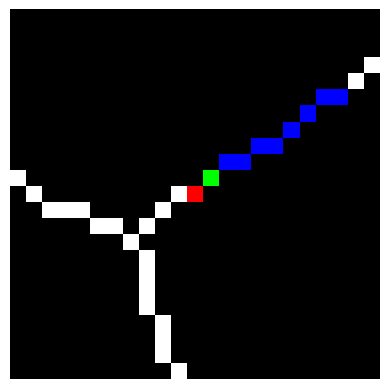

Angle is: 33.69006752597979


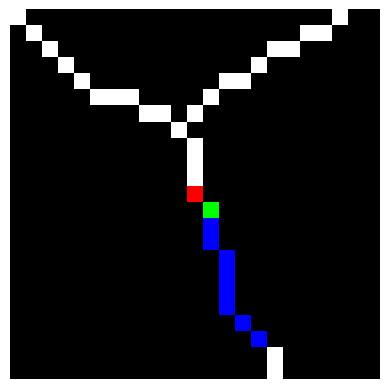

Angle is: 291.8014094863518
Descriptors for mapbox image 50.8001734_3.5924075.jpg:
[[69.67686317033706, 247.01128319791937, 335.55604521958344], [68.1985905136482, 243.43494882292202, 337.01128319791934], [33.69006752597979, 133.16925135197448, 291.8014094863518]]
Number of descriptors: 3
Descriptor of segmentation image:
[76.04549082686316, 253.42904883308614, 315.0]
Descriptor of mapbox image:
[69.67686317033706, 247.01128319791937, 335.55604521958344]
Angle of segmentation image: 76.04549082686316
Angle of mapbox image: 69.67686317033706
Angle of mapbox image: 247.01128319791937
Angle of mapbox image: 335.55604521958344
Best diff = 6.368627656526101 with angle 69.67686317033706
Angle of segmentation image: 253.42904883308614
Angle of mapbox image: 69.67686317033706
Angle of mapbox image: 247.01128319791937
Angle of mapbox image: 335.55604521958344
Best diff = 6.417765635166774 with angle 247.01128319791937
Angle of segmentation image: 315.0
Angle of mapbox image: 69.67686317033706
A

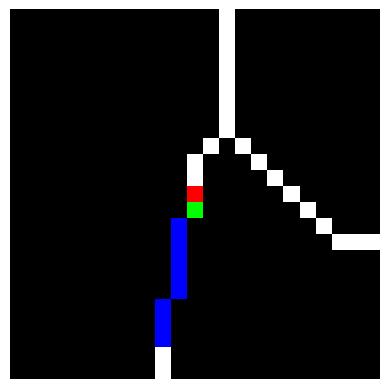

Angle is: 255.16500780574125


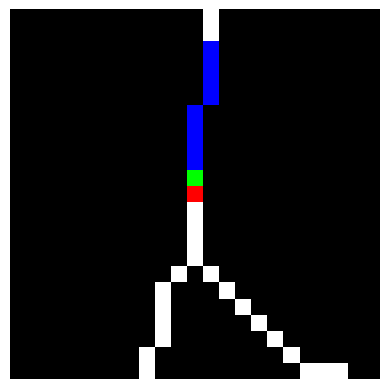

Angle is: 78.69006752597979


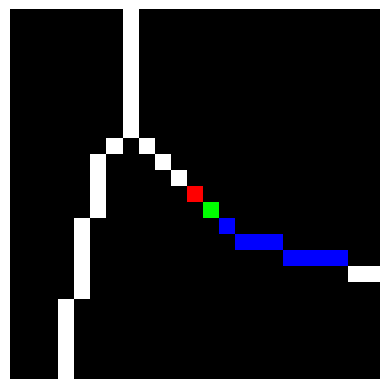

Angle is: 337.01128319791934


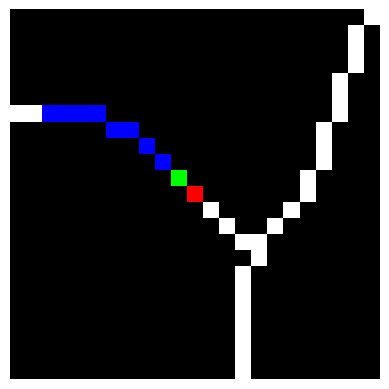

Angle is: 150.3299661843394


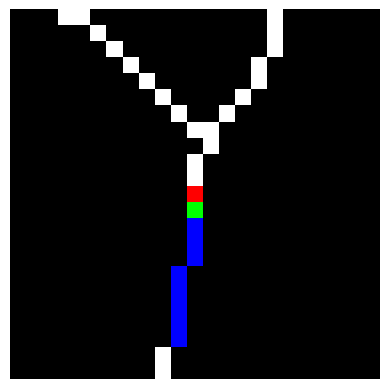

Angle is: 258.69006752597977


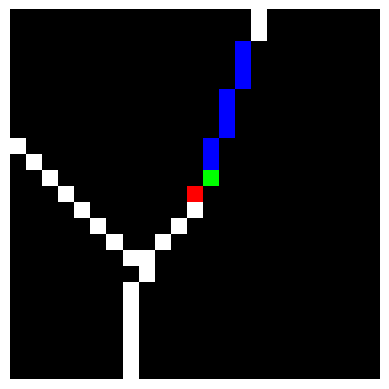

Angle is: 70.42687416958981
Descriptors for mapbox image 50.803516_3.5951223.jpg:
[[78.69006752597979, 255.16500780574125, 337.01128319791934], [70.42687416958981, 150.3299661843394, 258.69006752597977]]
Number of descriptors: 2
Descriptor of segmentation image:
[76.04549082686316, 253.42904883308614, 315.0]
Descriptor of mapbox image:
[78.69006752597979, 255.16500780574125, 337.01128319791934]
Angle of segmentation image: 76.04549082686316
Angle of mapbox image: 78.69006752597979
Angle of mapbox image: 255.16500780574125
Angle of mapbox image: 337.01128319791934
Best diff = 2.6445766991166266 with angle 78.69006752597979
Angle of segmentation image: 253.42904883308614
Angle of mapbox image: 78.69006752597979
Angle of mapbox image: 255.16500780574125
Angle of mapbox image: 337.01128319791934
Best diff = 1.7359589726551121 with angle 255.16500780574125
Angle of segmentation image: 315.0
Angle of mapbox image: 78.69006752597979
Angle of mapbox image: 255.16500780574125
Angle of mapbox im

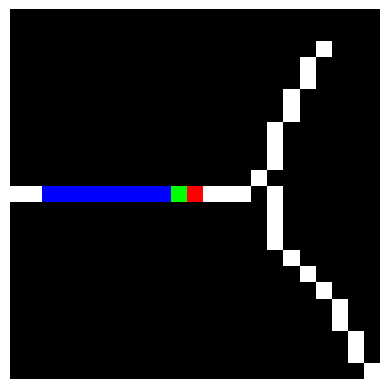

Angle is: 180
Count threshold not reached


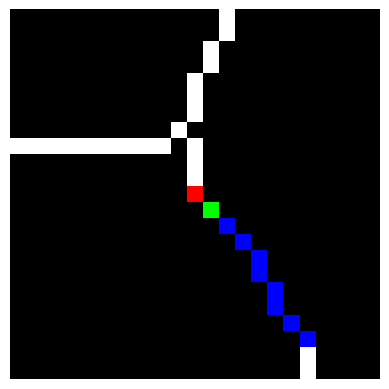

Angle is: 306.54497232282256


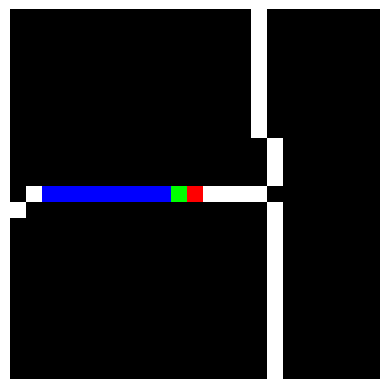

Angle is: 180


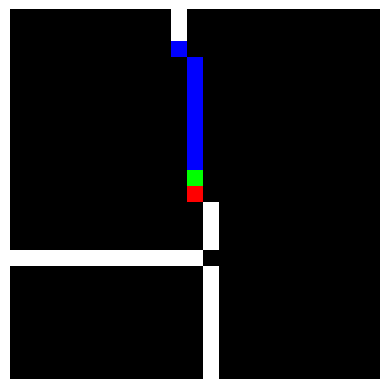

Angle is: 101.30993247402021


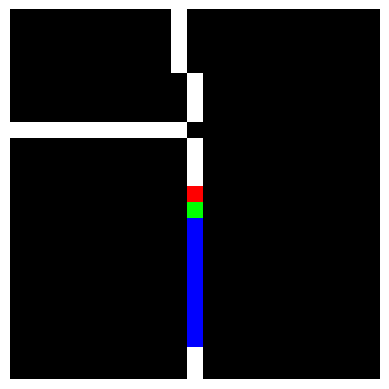

All x-values are the same
Angle is: 270


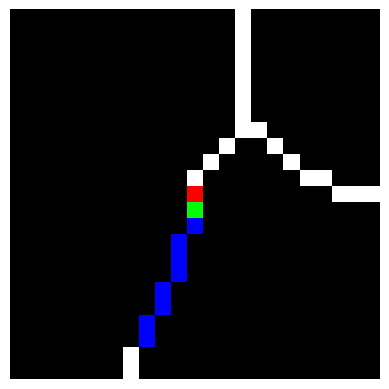

Angle is: 248.3607173574298


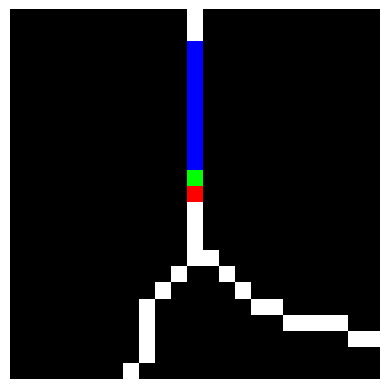

All x-values are the same
Angle is: 90


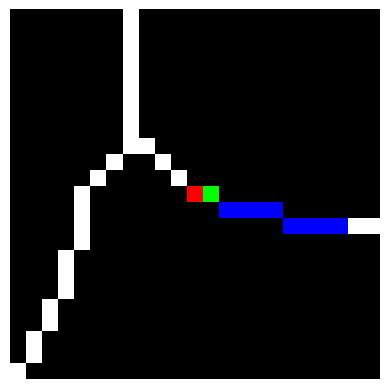

Angle is: 346.37300514010843
Descriptors for mapbox image 50.7989069_3.5945538.jpg:
[[180, 306.54497232282256], [101.30993247402021, 180, 270], [90, 248.3607173574298, 346.37300514010843]]
Number of descriptors: 3
Descriptor of segmentation image:
[76.04549082686316, 253.42904883308614, 315.0]
Descriptor of mapbox image:
[180, 306.54497232282256]
Descriptor of mapbox image:
[101.30993247402021, 180, 270]
Angle of segmentation image: 76.04549082686316
Angle of mapbox image: 101.30993247402021
Angle of mapbox image: 180
Angle of mapbox image: 270
Best diff = 25.264441647157057 with angle 101.30993247402021
Angle of segmentation image: 253.42904883308614
Angle of mapbox image: 101.30993247402021
Angle of mapbox image: 180
Angle of mapbox image: 270
Best diff = 16.570951166913858 with angle 270
Angle of segmentation image: 315.0
Angle of mapbox image: 101.30993247402021
Angle of mapbox image: 180
Angle of mapbox image: 270
Best diff = 135.0 with angle 180
Result = 138.33975724396385
Descri

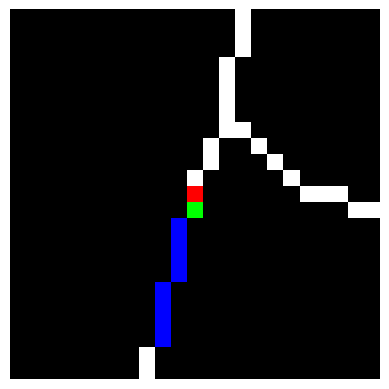

Angle is: 254.35775354279127


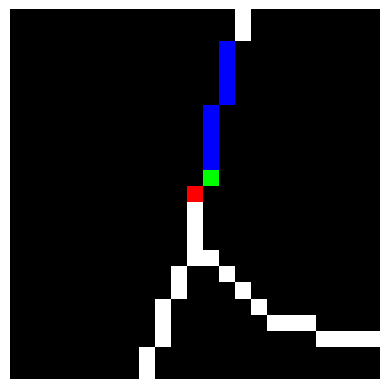

Angle is: 76.04549082686316


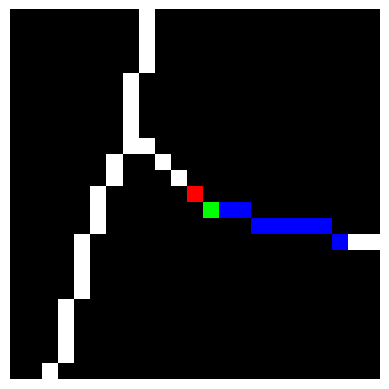

Angle is: 345.71890426402916


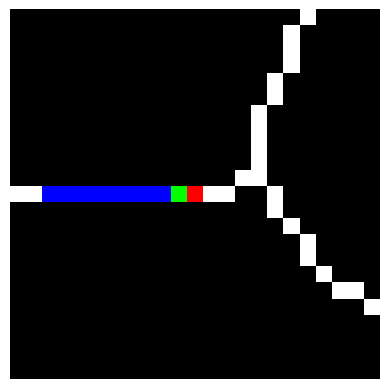

Angle is: 180


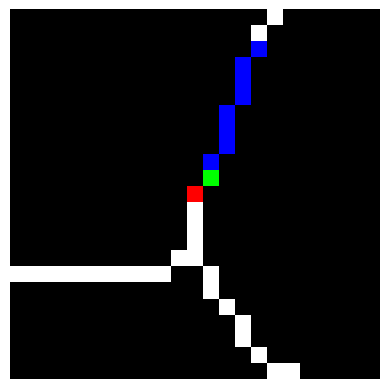

Angle is: 67.72973207994468


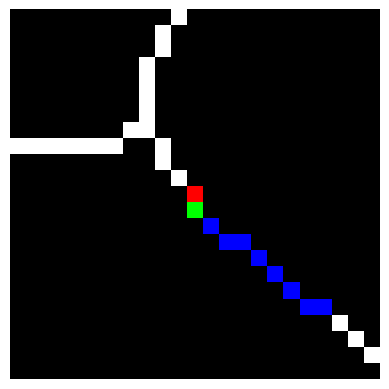

Angle is: 320.1036514085458


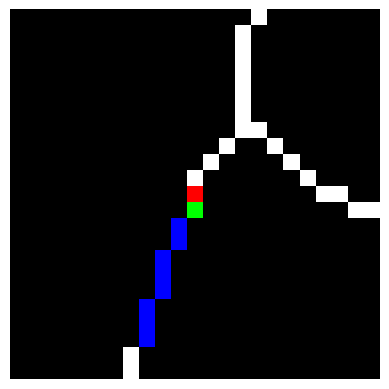

Angle is: 248.36071735742976


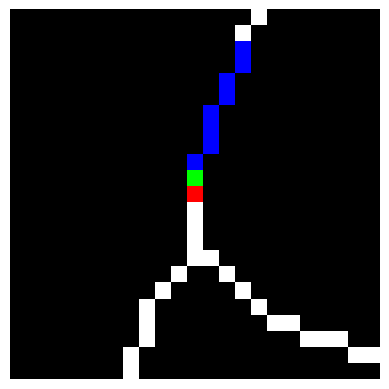

Angle is: 68.36071735742978


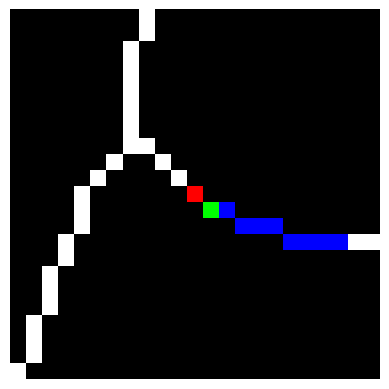

Angle is: 341.87813975209866


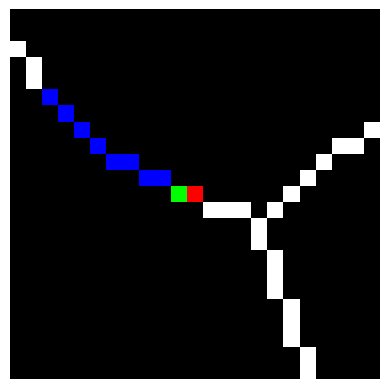

Angle is: 146.3099324740202


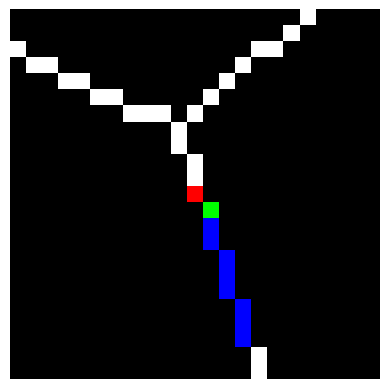

Angle is: 289.57312583041016


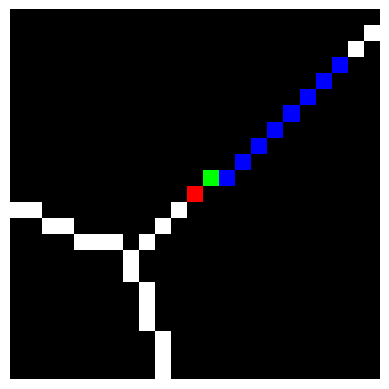

Angle is: 42.082992713372285
Descriptors for mapbox image 50.8000803_3.5916233.jpg:
[[76.04549082686316, 254.35775354279127, 345.71890426402916], [67.72973207994468, 180, 320.1036514085458], [68.36071735742978, 248.36071735742976, 341.87813975209866], [42.082992713372285, 146.3099324740202, 289.57312583041016]]
Number of descriptors: 4
Descriptor of segmentation image:
[76.04549082686316, 253.42904883308614, 315.0]
Descriptor of mapbox image:
[76.04549082686316, 254.35775354279127, 345.71890426402916]
Angle of segmentation image: 76.04549082686316
Angle of mapbox image: 76.04549082686316
Angle of mapbox image: 254.35775354279127
Angle of mapbox image: 345.71890426402916
Best diff = 0.0 with angle 76.04549082686316
Angle of segmentation image: 253.42904883308614
Angle of mapbox image: 76.04549082686316
Angle of mapbox image: 254.35775354279127
Angle of mapbox image: 345.71890426402916
Best diff = 0.92870470970513 with angle 254.35775354279127
Angle of segmentation image: 315.0
Angle of 

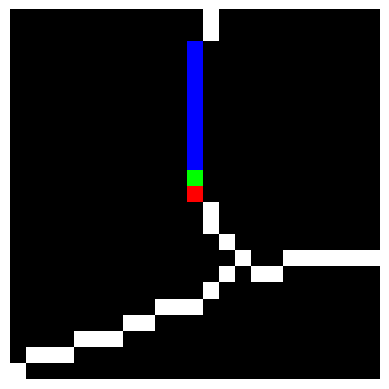

All x-values are the same
Angle is: 90


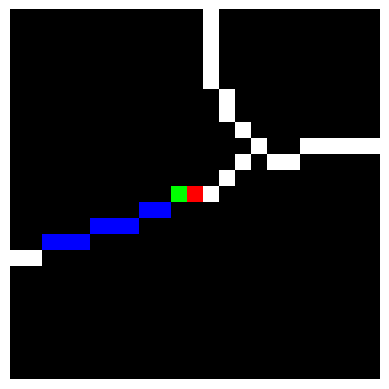

Angle is: 200.2892005377698


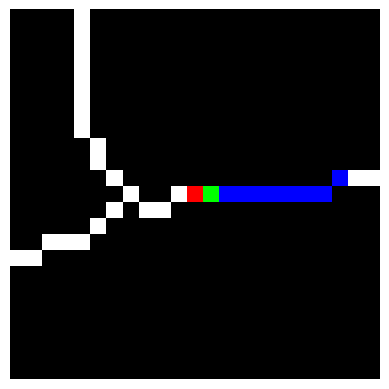

Angle is: 3.1221304621157078
Descriptors for mapbox image 50.801701_3.5923755.jpg:
[[3.1221304621157078, 90, 200.2892005377698]]
Number of descriptors: 1
Descriptor of segmentation image:
[76.04549082686316, 253.42904883308614, 315.0]
Descriptor of mapbox image:
[3.1221304621157078, 90, 200.2892005377698]
Angle of segmentation image: 76.04549082686316
Angle of mapbox image: 3.1221304621157078
Angle of mapbox image: 90
Angle of mapbox image: 200.2892005377698
Best diff = 13.954509173136842 with angle 90
Angle of segmentation image: 253.42904883308614
Angle of mapbox image: 3.1221304621157078
Angle of mapbox image: 90
Angle of mapbox image: 200.2892005377698
Best diff = 53.13984829531634 with angle 200.2892005377698
Angle of segmentation image: 315.0
Angle of mapbox image: 3.1221304621157078
Angle of mapbox image: 90
Angle of mapbox image: 200.2892005377698
Best diff = 48.122130462115706 with angle 3.1221304621157078
Result = 73.03636931916373
Descriptor of segmentation image:
[45.0, 180

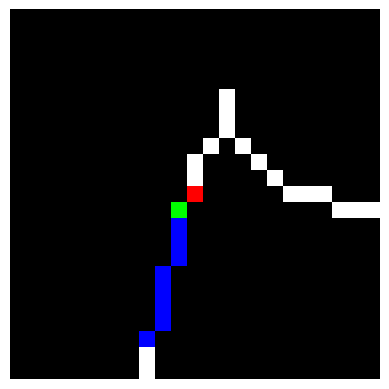

Angle is: 253.17859010995915
Count threshold not reached


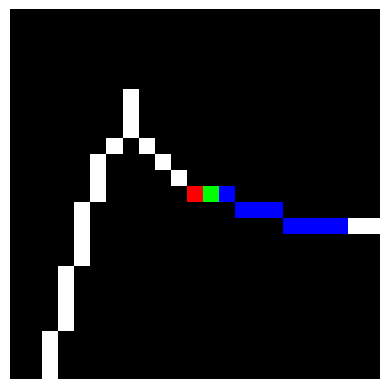

Angle is: 344.7448812969422


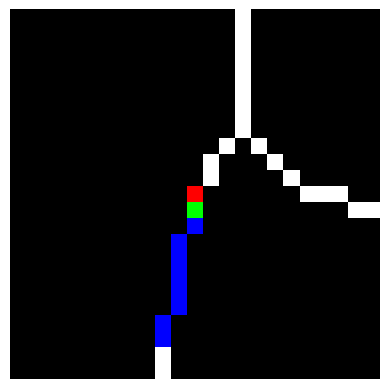

Angle is: 255.16500780574125


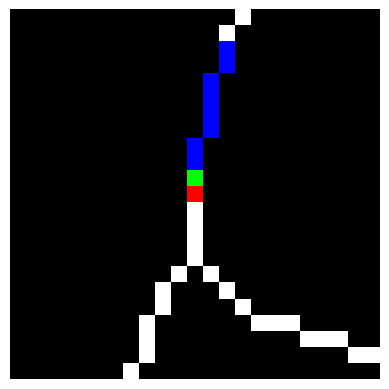

Angle is: 74.35775354279127


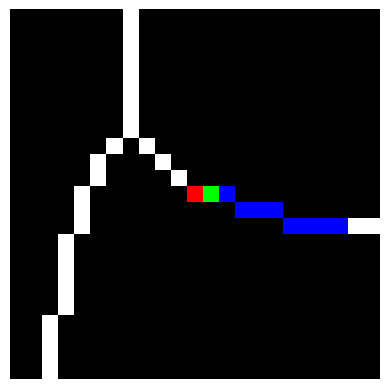

Angle is: 344.7448812969422


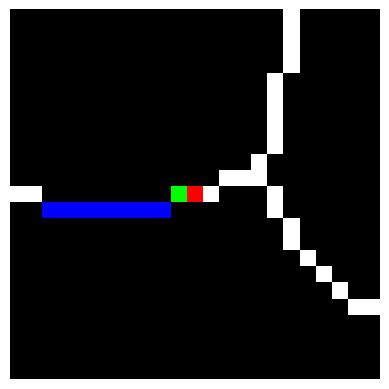

Angle is: 185.53863753279052


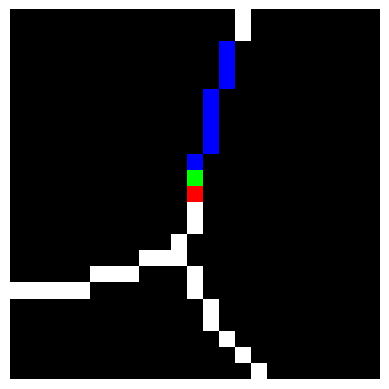

Angle is: 74.05460409907714


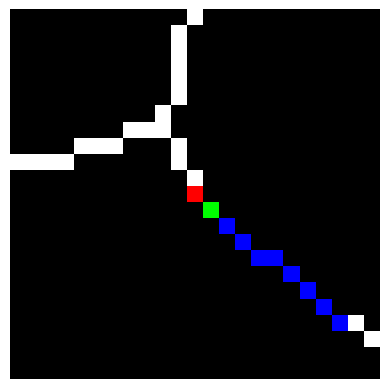

Angle is: 319.68589983950267


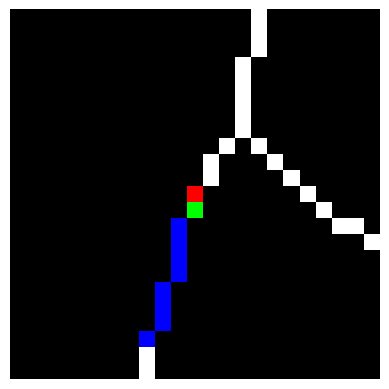

Angle is: 251.7054817280153


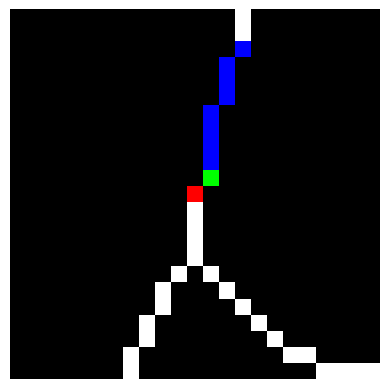

Angle is: 73.05077576617856


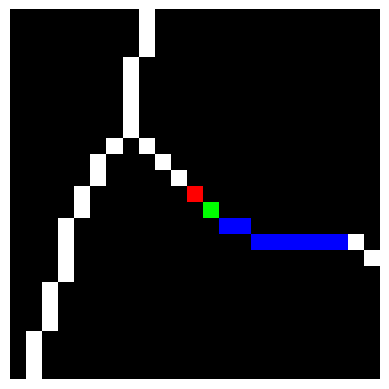

Angle is: 343.4601759987711
Descriptors for mapbox image 50.8000098_3.5914461.jpg:
[[253.17859010995915, 344.7448812969422], [74.35775354279127, 255.16500780574125, 344.7448812969422], [74.05460409907714, 185.53863753279052, 319.68589983950267], [73.05077576617856, 251.7054817280153, 343.4601759987711]]
Number of descriptors: 4
Descriptor of segmentation image:
[76.04549082686316, 253.42904883308614, 315.0]
Descriptor of mapbox image:
[253.17859010995915, 344.7448812969422]
Descriptor of mapbox image:
[74.35775354279127, 255.16500780574125, 344.7448812969422]
Angle of segmentation image: 76.04549082686316
Angle of mapbox image: 74.35775354279127
Angle of mapbox image: 255.16500780574125
Angle of mapbox image: 344.7448812969422
Best diff = 1.6877372840718863 with angle 74.35775354279127
Angle of segmentation image: 253.42904883308614
Angle of mapbox image: 74.35775354279127
Angle of mapbox image: 255.16500780574125
Angle of mapbox image: 344.7448812969422
Best diff = 1.7359589726551121 

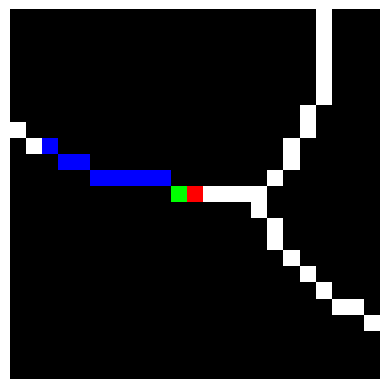

Angle is: 164.42217422568896


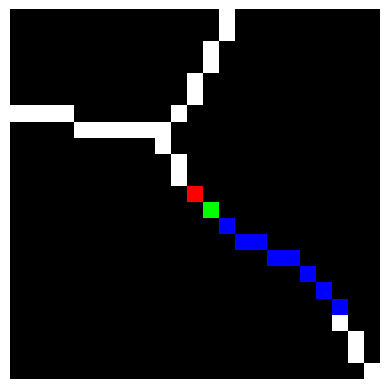

Angle is: 324.65989307844234


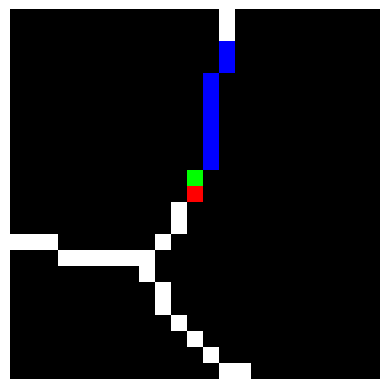

Angle is: 75.96375653207353


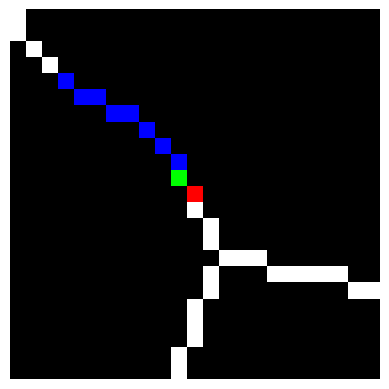

Angle is: 140.71975752953813


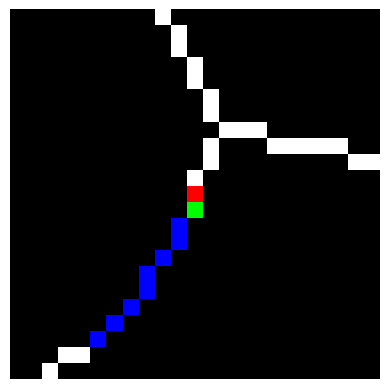

Angle is: 235.25119875081742


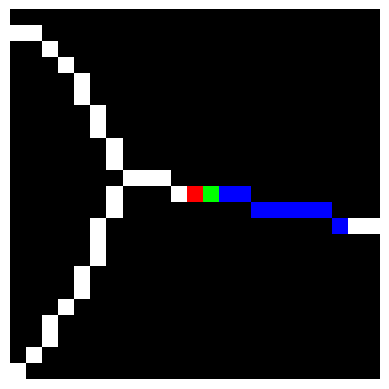

Angle is: 348.69006752597977


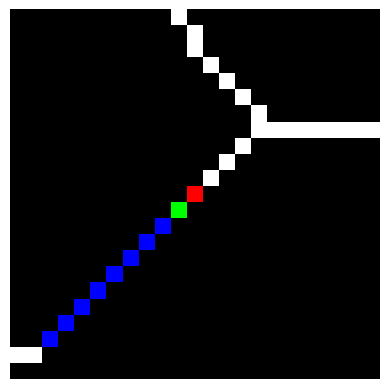

Angle is: 225.00000000000003


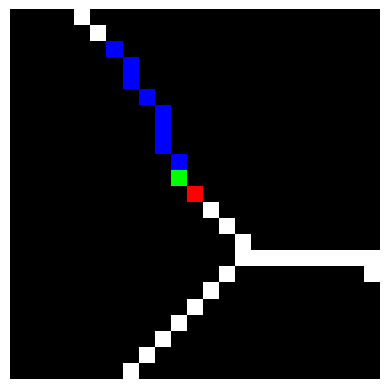

Angle is: 118.07248693585296
Count threshold not reached


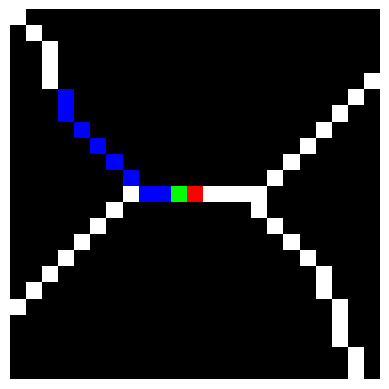

Angle is: 143.22880299642554


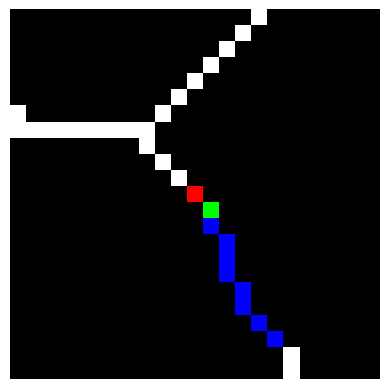

Angle is: 296.9697573188014


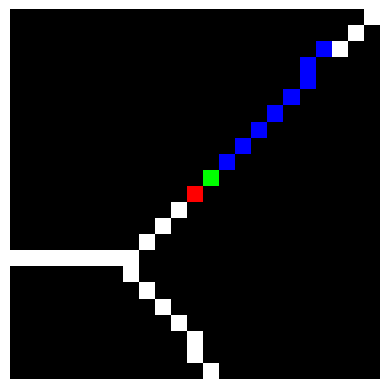

Angle is: 47.56975510495161
Descriptors for mapbox image 50.8009171_3.5921758.jpg:
[[75.96375653207353, 164.42217422568896, 324.65989307844234], [140.71975752953813, 235.25119875081742, 348.69006752597977], [47.56975510495161, 118.07248693585296, 143.22880299642554, 225.00000000000003, 296.9697573188014]]
Number of descriptors: 3
Descriptor of segmentation image:
[76.04549082686316, 253.42904883308614, 315.0]
Descriptor of mapbox image:
[75.96375653207353, 164.42217422568896, 324.65989307844234]
Angle of segmentation image: 76.04549082686316
Angle of mapbox image: 75.96375653207353
Angle of mapbox image: 164.42217422568896
Angle of mapbox image: 324.65989307844234
Best diff = 0.08173429478962646 with angle 75.96375653207353
Angle of segmentation image: 253.42904883308614
Angle of mapbox image: 75.96375653207353
Angle of mapbox image: 164.42217422568896
Angle of mapbox image: 324.65989307844234
Best diff = 71.2308442453562 with angle 324.65989307844234
Angle of segmentation image: 315.0

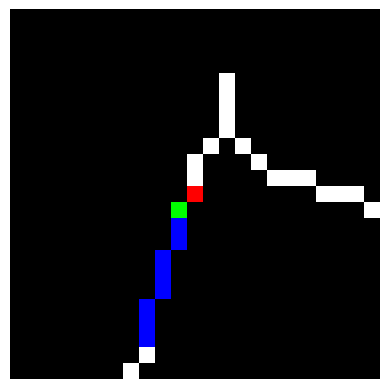

Angle is: 250.4268741695898
Count threshold not reached


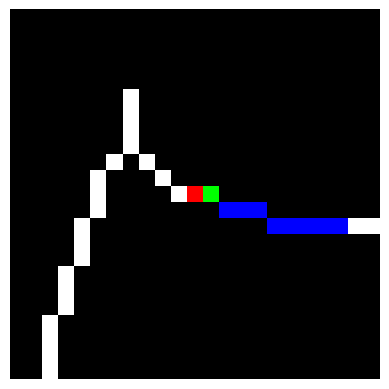

Angle is: 346.04549082686316


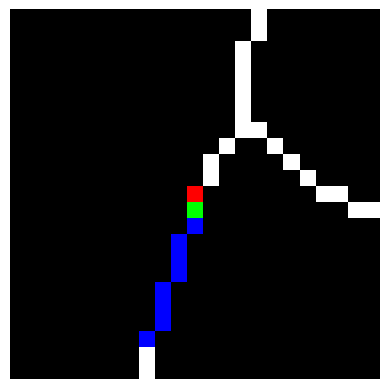

Angle is: 250.4268741695898


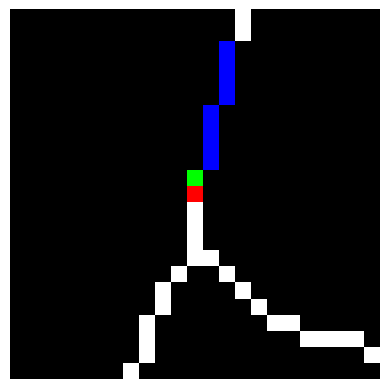

Angle is: 74.35775354279127


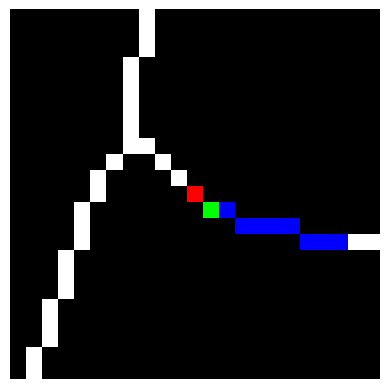

Angle is: 342.82409638425327


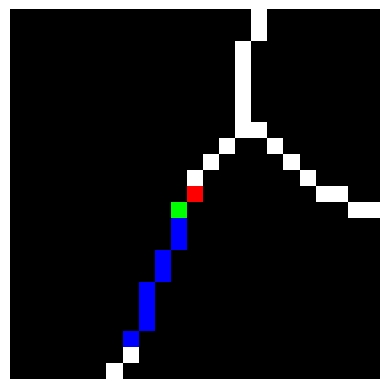

Angle is: 247.01128319791937


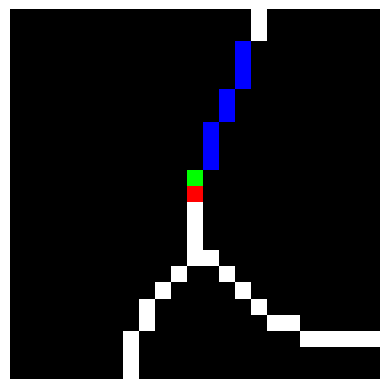

Angle is: 68.19859051364818


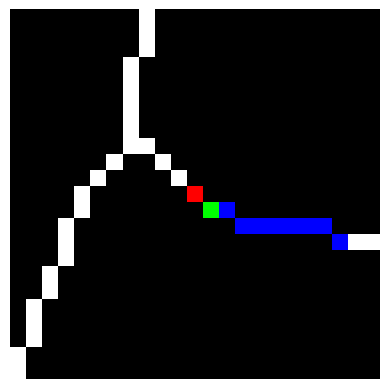

Angle is: 346.7014296695057


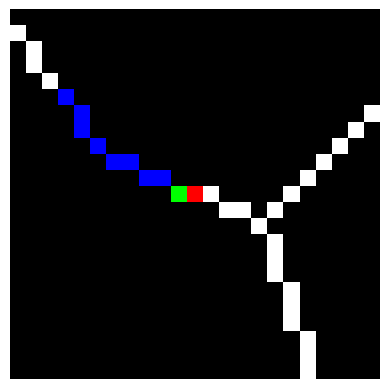

Angle is: 144.37487207825768


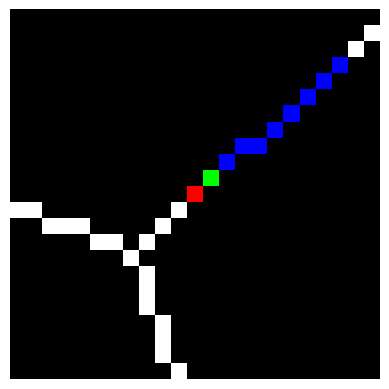

Angle is: 40.51539399045538


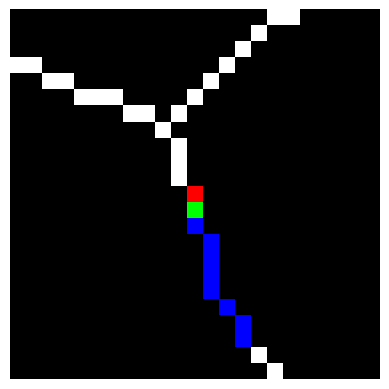

Angle is: 291.8014094863518
Descriptors for mapbox image 50.8002026_3.592017.jpg:
[[250.4268741695898, 346.04549082686316], [74.35775354279127, 250.4268741695898, 342.82409638425327], [68.19859051364818, 247.01128319791937, 346.7014296695057], [40.51539399045538, 144.37487207825768, 291.8014094863518]]
Number of descriptors: 4
Descriptor of segmentation image:
[76.04549082686316, 253.42904883308614, 315.0]
Descriptor of mapbox image:
[250.4268741695898, 346.04549082686316]
Descriptor of mapbox image:
[74.35775354279127, 250.4268741695898, 342.82409638425327]
Angle of segmentation image: 76.04549082686316
Angle of mapbox image: 74.35775354279127
Angle of mapbox image: 250.4268741695898
Angle of mapbox image: 342.82409638425327
Best diff = 1.6877372840718863 with angle 74.35775354279127
Angle of segmentation image: 253.42904883308614
Angle of mapbox image: 74.35775354279127
Angle of mapbox image: 250.4268741695898
Angle of mapbox image: 342.82409638425327
Best diff = 3.0021746634963336 w

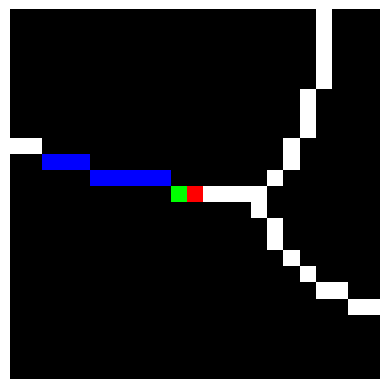

Angle is: 167.3609375593699


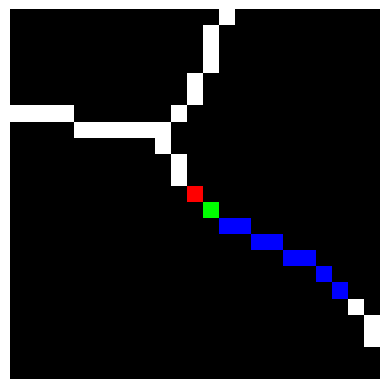

Angle is: 329.29225507742154


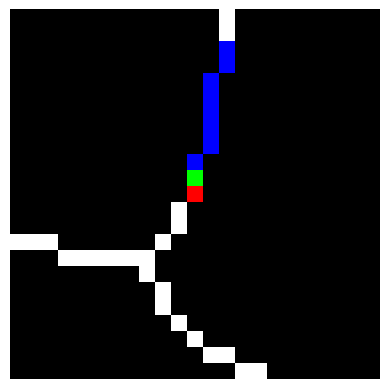

Angle is: 75.16500780574127


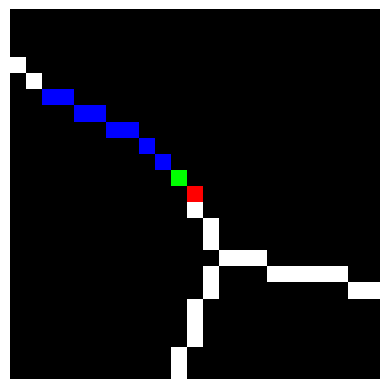

Angle is: 146.3099324740202


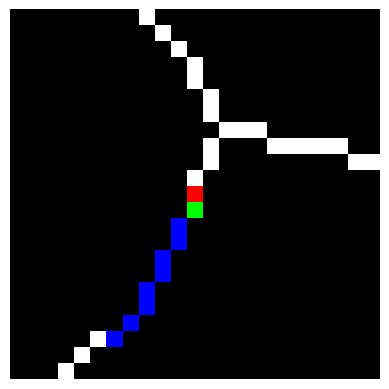

Angle is: 240.7707807325368


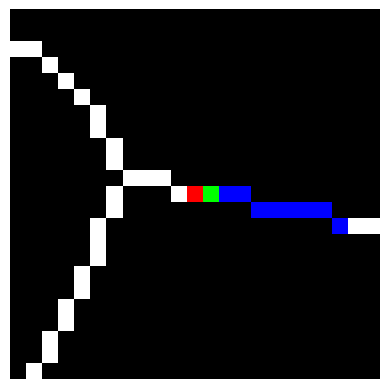

Angle is: 348.69006752597977


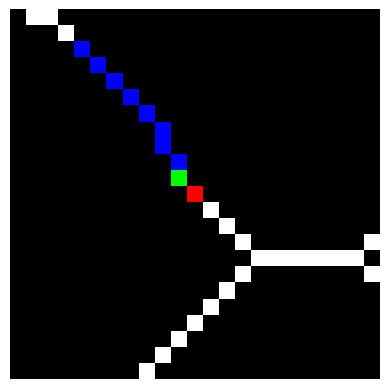

Angle is: 128.03962624250565


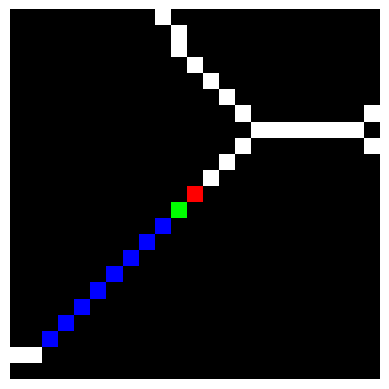

Angle is: 225.00000000000003
Count threshold not reached
Count threshold not reached


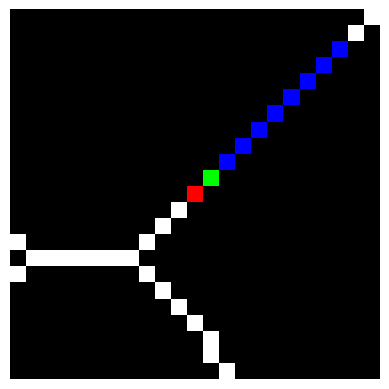

Angle is: 45.0


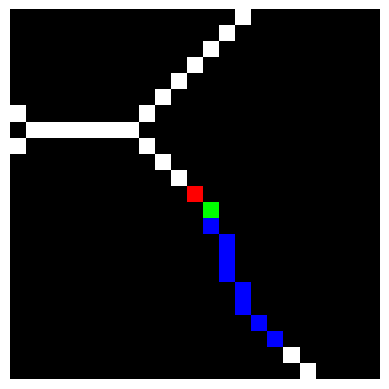

Angle is: 296.9697573188014
Descriptors for mapbox image 50.8009587_3.5921857.jpg:
[[75.16500780574127, 167.3609375593699, 329.29225507742154], [146.3099324740202, 240.7707807325368, 348.69006752597977], [45.0, 128.03962624250565, 225.00000000000003, 296.9697573188014]]
Number of descriptors: 3
Descriptor of segmentation image:
[76.04549082686316, 253.42904883308614, 315.0]
Descriptor of mapbox image:
[75.16500780574127, 167.3609375593699, 329.29225507742154]
Angle of segmentation image: 76.04549082686316
Angle of mapbox image: 75.16500780574127
Angle of mapbox image: 167.3609375593699
Angle of mapbox image: 329.29225507742154
Best diff = 0.8804830211218899 with angle 75.16500780574127
Angle of segmentation image: 253.42904883308614
Angle of mapbox image: 75.16500780574127
Angle of mapbox image: 167.3609375593699
Angle of mapbox image: 329.29225507742154
Best diff = 75.8632062443354 with angle 329.29225507742154
Angle of segmentation image: 315.0
Angle of mapbox image: 75.1650078057412

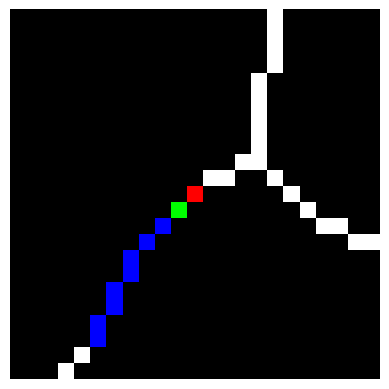

Angle is: 235.07795507138053


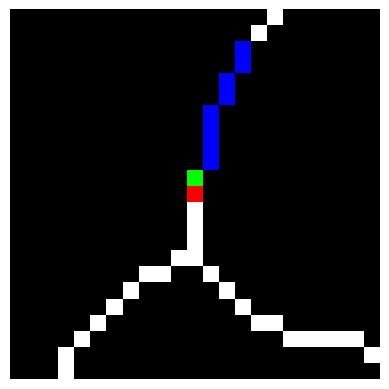

Angle is: 69.62356478616361


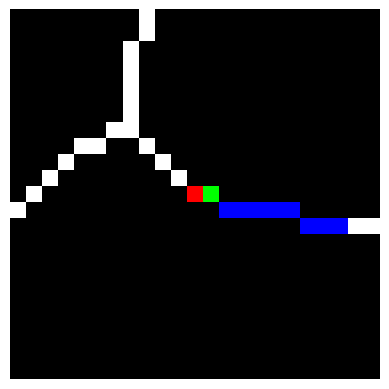

Angle is: 347.3609375593699


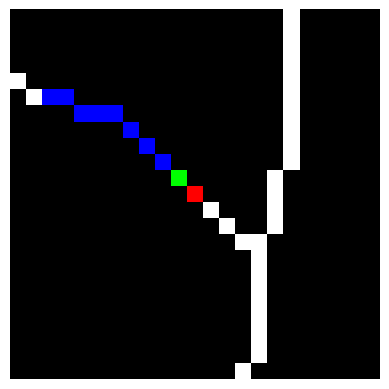

Angle is: 146.07020257793937


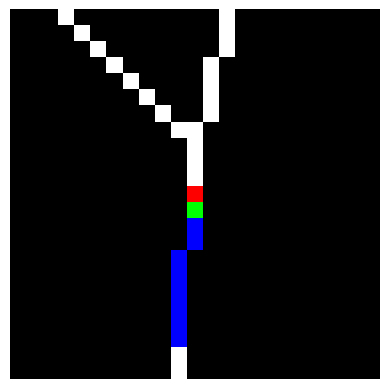

Angle is: 258.69006752597977


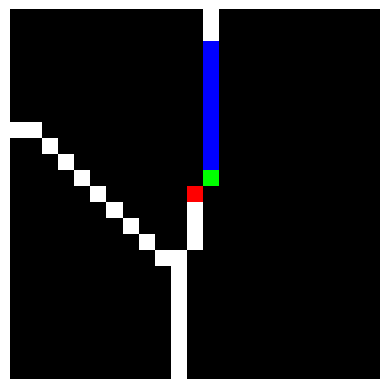

Angle is: 78.69006752597979
Descriptors for mapbox image 50.8037365_3.5944906.jpg:
[[69.62356478616361, 235.07795507138053, 347.3609375593699], [78.69006752597979, 146.07020257793937, 258.69006752597977]]
Number of descriptors: 2
Descriptor of segmentation image:
[76.04549082686316, 253.42904883308614, 315.0]
Descriptor of mapbox image:
[69.62356478616361, 235.07795507138053, 347.3609375593699]
Angle of segmentation image: 76.04549082686316
Angle of mapbox image: 69.62356478616361
Angle of mapbox image: 235.07795507138053
Angle of mapbox image: 347.3609375593699
Best diff = 6.421926040699546 with angle 69.62356478616361
Angle of segmentation image: 253.42904883308614
Angle of mapbox image: 69.62356478616361
Angle of mapbox image: 235.07795507138053
Angle of mapbox image: 347.3609375593699
Best diff = 18.351093761705613 with angle 235.07795507138053
Angle of segmentation image: 315.0
Angle of mapbox image: 69.62356478616361
Angle of mapbox image: 235.07795507138053
Angle of mapbox image

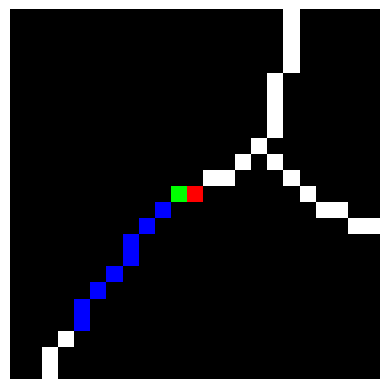

Angle is: 229.34512930106865


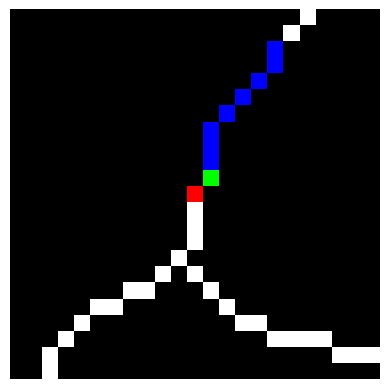

Angle is: 57.63821031939823


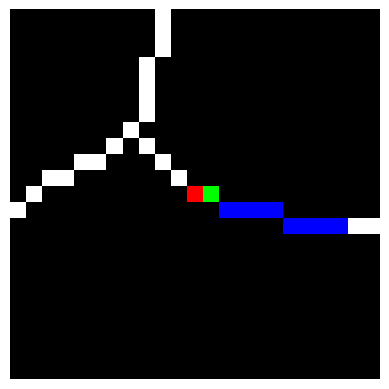

Angle is: 346.37300514010843


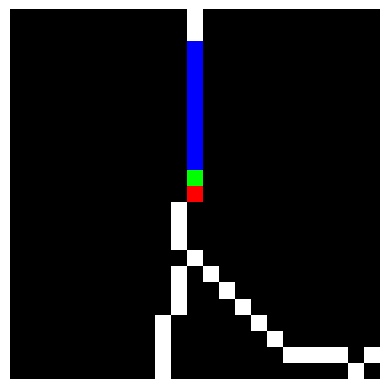

All x-values are the same
Angle is: 90


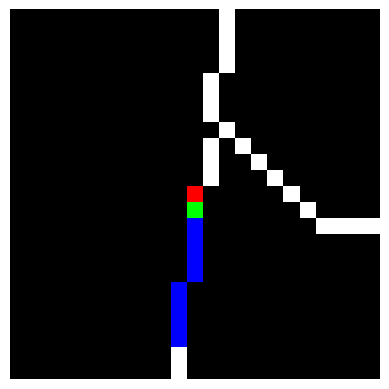

Angle is: 258.69006752597977


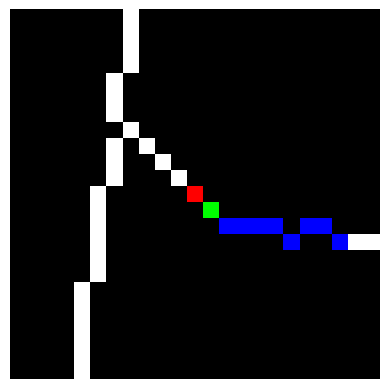

Angle is: 347.3609375593699


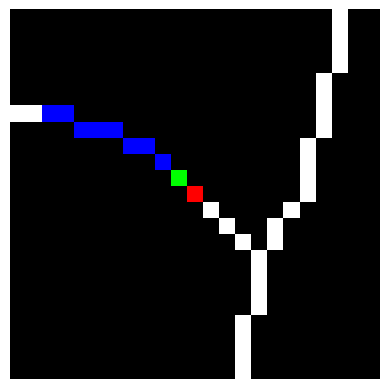

Angle is: 152.19854122006586


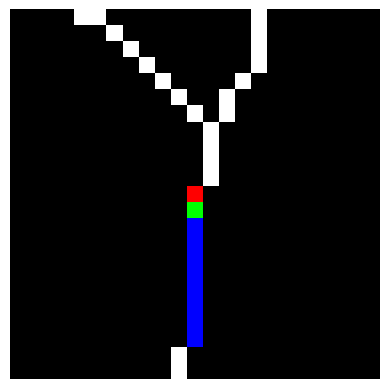

All x-values are the same
Angle is: 270


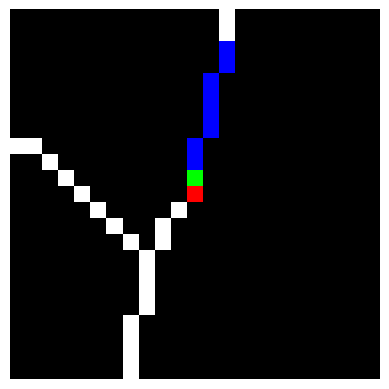

Angle is: 74.35775354279127
Descriptors for mapbox image 50.8035677_3.5949456.jpg:
[[57.63821031939823, 229.34512930106865, 346.37300514010843], [90, 258.69006752597977, 347.3609375593699], [74.35775354279127, 152.19854122006586, 270]]
Number of descriptors: 3
Descriptor of segmentation image:
[76.04549082686316, 253.42904883308614, 315.0]
Descriptor of mapbox image:
[57.63821031939823, 229.34512930106865, 346.37300514010843]
Angle of segmentation image: 76.04549082686316
Angle of mapbox image: 57.63821031939823
Angle of mapbox image: 229.34512930106865
Angle of mapbox image: 346.37300514010843
Best diff = 18.407280507464925 with angle 57.63821031939823
Angle of segmentation image: 253.42904883308614
Angle of mapbox image: 57.63821031939823
Angle of mapbox image: 229.34512930106865
Angle of mapbox image: 346.37300514010843
Best diff = 24.08391953201749 with angle 229.34512930106865
Angle of segmentation image: 315.0
Angle of mapbox image: 57.63821031939823
Angle of mapbox image: 229.34

In [20]:
best_mb_image = None
scores = dict()
visualize = False 

for mb_image in os.listdir(mapbox_imgs_dir_path) : 
    best_results = []
    mb_image_path = os.path.join(mapbox_imgs_dir_path, mb_image)
    print(50*"*")
    print(f"Mapbox image: {mb_image}")
    print(50*"*")
    mb_image_bgr = cv2.imread(mb_image_path)
    if visualize : 
        plot_image(mb_image_bgr)
    des = find_descriptors_in_mapbox_image(mb_image_path, mb_image, vis=visualize)
    print(f"Descriptors for mapbox image {mb_image}:")
    print(des)

    # matching process
    if des is not None and segm_img_des is not None :
        print(f"Number of descriptors: {len(des)}")
        for des_segm in segm_img_des :
            best_result_per_des = 1000 # best descriptor match for descriptor des_segm of segmentation image
            print(f"Descriptor of segmentation image:")
            print(des_segm)
            for des_mb in des :
                print(f"Descriptor of mapbox image:")
                print(des_mb)

                if len(des_mb) < len(des_segm) : 
                    continue

                result = 0
                processed_angles = []
                for angle_des_segm in des_segm :
                    print(f"Angle of segmentation image: {angle_des_segm}") 
                    best_diff = 1000
                    for angle_des_mb in des_mb :
                        print(f"Angle of mapbox image: {angle_des_mb}")
                        if angle_des_mb in processed_angles : 
                            continue
                        diff = min(abs(angle_des_segm-angle_des_mb), abs((angle_des_segm+360)-angle_des_mb), abs((angle_des_mb+360)-angle_des_segm))
                        if diff < best_diff :
                            best_diff = diff
                            best_angle_des_mb = angle_des_mb
                    
                    print(f"Best diff = {best_diff} with angle {best_angle_des_mb}")
                    processed_angles.append(best_angle_des_mb)
                    result += best_diff**2
                
                
                result = math.sqrt(result)
                print(f"Result = {result}")
            
                if result < best_result_per_des :
                    best_result_per_des = result

            best_results.append(best_result_per_des)
        
        score =  math.sqrt(np.sum(best_results))
        print(f"Score = {score}")
        
        # make sure there is at least one best result that is below the threshold 
        threshold = 40

        # If at least one result is below the threshold, add the score to the dictionary
        # if any(result < threshold for result in best_results) :
        #   print(f"At least one result is below the threshold, add the score to the dictionary for mapbox image {mb_image}")
        #   scores[mb_image] = score
        scores[mb_image] = score
    else:
        continue


# Get the lowest three values using sorted() and dictionary items()
lowest_values = sorted(scores.values())[:3]
print(50*"*")
print("Top 3 results:")
print(50*"*")
for value in lowest_values:
    # For each value, get the corresponding key
    for key in scores.keys():
        if scores[key] == value:
            print(f"Score = {value} with mapbox image {key}")